In [2]:
import geopandas as gpd
import pandas as pd
import pygris
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
import matplotlib
from tqdm.notebook import tqdm
import osmnx as ox
import contextily as cx
import json

plt.rcParams["figure.figsize"] = [8, 8]
matplotlib.rcParams['figure.dpi'] = 300

### Download PM 2.5 hyperlocal measurements from MIT-Seansable City

In [3]:
urls = [
    f"https://raw.githubusercontent.com/MIT-Senseable-City-Lab/OSCS/main/Explore/Datasets/NYC_Pilot2_PM_Part{i}.csv"
    for i in [1, 2, 3]
]

info = {
    "target": "pm25",
    "lat": "latitude",
    "lon": "longitude",
    "time": "time",
    "time_input_format": "unix",
    "time_zone": "US/Eastern",
    "features": ["temperature", "humidity"],
    "ids": ["SensorID"],
}

# download the three datasets
pts = []
for url in urls:
    chunk = pd.read_csv(url)
    pts.append(chunk)
pts = pd.concat(pts, ignore_index=True)

# convert the time column to local time
pts["time"] = pd.to_datetime(pts[info["time"]], unit="s")
pts["time"] = pts["time"].dt.tz_localize("UTC").dt.tz_convert(info["time_zone"])

# filter columns
cols = (
    info["ids"]
    + [info["time"], info["lon"], info["lat"], info["target"]]
    + info["features"]
)
pts = pts[cols]

# rename lon/lat columns
pts = pts.rename(columns={info["lon"]: "lon", info["lat"]: "lat"})

display(pts)

SensorID                      time        lon        lat      pm25  \
0       NYCP2_CS01A 2021-09-10 08:35:04-04:00 -73.869316  40.847672  4.508813   
1       NYCP2_CS01A 2021-09-10 08:35:08-04:00 -73.869316  40.847668  5.462420   
2       NYCP2_CS01A 2021-09-10 08:35:13-04:00 -73.869362  40.847649  5.154881   
3       NYCP2_CS01A 2021-09-10 08:35:18-04:00 -73.869362  40.847649  4.508813   
4       NYCP2_CS01A 2021-09-10 08:35:23-04:00 -73.869362  40.847649  5.539503   
...             ...                       ...        ...        ...       ...   
515912  NYCP2_CS05A 2021-09-24 07:04:30-04:00 -73.870689  40.845146  5.005314   
515913  NYCP2_CS05A 2021-09-24 07:04:35-04:00 -73.870689  40.845150  3.534440   
515914  NYCP2_CS05A 2021-09-24 07:04:40-04:00 -73.870689  40.845146  5.444739   
515915  NYCP2_CS05A 2021-09-24 07:04:45-04:00 -73.870697  40.845139  3.432193   
515916  NYCP2_CS05A 2021-09-24 07:04:50-04:00 -73.870697  40.845135  2.895179   

        temperature  humidity  
0              23.7      57.3  
1              23.7      57.8  
2              23.7      57.8  
3              23.6      57.6  
4              23.6      57.5  
...             ...       ...  
515912        -17.5       0.0  
515913        -17.5       0.0  
515914        -17.5       0.0  
515915        -17.5       0.0  
515916        -17.5       0.0  

[515917 rows x 7 columns]

### Coarsen points / keep polygons that contain points

In [4]:
# projection useful throughout
wgs84 = "EPSG:4326"  # unit is degrees
mercator = "EPSG:3857"  # unit is meters, useful for meter computations

#  ==== RANK 0: POINTS ====
# to reduce dim by aggregating measurements by time and location
delta_s = 0.0002 # 0.0001 deg ~ 11m
delta_t = "5min"
pts["lon"] = delta_s * np.round(pts.lon / delta_s)
pts["lat"] = delta_s * np.round(pts.lat / delta_s)
pts["time"] = pts.time.dt.round(delta_t, ambiguous="NaT")
group_cols = ["SensorID", "time", "lon", "lat"]
value_cols = ["temperature", "humidity", "pm25"]
pts = pts.groupby(group_cols)[value_cols].median().reset_index()

# convert to geopandas
geom = gpd.points_from_xy(pts.lon, pts.lat, crs=wgs84)
pts = gpd.GeoDataFrame(pts, geometry=geom)
print("Processed points")
display(pts)

# ==== RANK 1: ROADS =====
roads = pygris.roads(state="NY", county="Bronx").to_crs(wgs84)
print("Roads")
display(roads)

# ==== RANK 2: TRACTS ====
tracts = pygris.tracts(
    state="NY", county="Bronx", year=2020, cache=True, cb=True
).to_crs(wgs84)
tracts["TRACTCE"] = tracts["TRACTCE"].astype(int)
tracts.set_index("TRACTCE", inplace=True)
print("Tracts")
display(tracts)

Processed points


SensorID                      time      lon      lat  temperature  \
0       NYCP2_CS01A 2021-09-10 08:35:00-04:00 -73.8694  40.8476        23.50   
1       NYCP2_CS01A 2021-09-10 08:40:00-04:00 -73.8694  40.8476        23.05   
2       NYCP2_CS01A 2021-09-10 08:40:00-04:00 -73.8694  40.8478        22.50   
3       NYCP2_CS01A 2021-09-10 08:45:00-04:00 -73.8698  40.8470        22.00   
4       NYCP2_CS01A 2021-09-10 08:45:00-04:00 -73.8698  40.8472        22.20   
...             ...                       ...      ...      ...          ...   
151120  NYCP2_CS05A 2021-09-23 15:10:00-04:00 -73.8686  40.8486        28.40   
151121  NYCP2_CS05A 2021-09-23 15:15:00-04:00 -73.8706  40.8452        28.40   
151122  NYCP2_CS05A 2021-09-23 15:20:00-04:00 -73.8706  40.8452        28.50   
151123  NYCP2_CS05A 2021-09-24 07:00:00-04:00 -73.8706  40.8452        14.35   
151124  NYCP2_CS05A 2021-09-24 07:05:00-04:00 -73.8706  40.8452       -17.50   

        humidity       pm25                    geometry  
0          57.65   5.368103  POINT (-73.86940 40.84760)  
1          58.75   5.314127  POINT (-73.86940 40.84760)  
2          59.80   5.575798  POINT (-73.86940 40.84780)  
3          59.40   5.564330  POINT (-73.86980 40.84700)  
4          59.15   5.433488  POINT (-73.86980 40.84720)  
...          ...        ...                         ...  
151120     66.00  11.933509  POINT (-73.86860 40.84860)  
151121     64.90  12.101344  POINT (-73.87060 40.84520)  
151122     65.00  12.101344  POINT (-73.87060 40.84520)  
151123    100.00   2.859580  POINT (-73.87060 40.84520)  
151124      0.00   3.534440  POINT (-73.87060 40.84520)  

[151125 rows x 8 columns]

Using the default year of 2021
Using FIPS code '36' for input 'NY'
Using FIPS code '005' for input 'Bronx'
Roads


LINEARID             FULLNAME RTTYP  MTFCC  \
0      1104691956808       Bryant Ave Ovp     M  S1710   
1       110391525903     Putnam Ave W Exd     M  S1400   
2       110391524230       E 177th St Exd     M  S1400   
3       110391523610          5th Ave Exd     M  S1400   
4       110391528344  Cross Bx Svc Rd Exd     O  S1640   
...              ...                  ...   ...    ...   
3348  11012812945824                 None  None  S1780   
3349    110391526368           Dogwood Dr     M  S1400   
3350  11012812959297                 None  None  S1710   
3351    110391527948           Spencer Pl     M  S1400   
3352   1103717136086           McLean Ave     M  S1400   

                                               geometry  
0     LINESTRING (-73.88891 40.82181, -73.88857 40.8...  
1     LINESTRING (-73.90028 40.88302, -73.90014 40.8...  
2     LINESTRING (-73.80205 40.81721, -73.80117 40.8...  
3     LINESTRING (-73.81216 40.82314, -73.81230 40.8...  
4     LINESTRING (-73.88568 40.84051, -73.88492 40.8...  
...                                                 ...  
3348  LINESTRING (-73.86609 40.82136, -73.86542 40.8...  
3349  LINESTRING (-73.86176 40.84151, -73.86127 40.8...  
3350  LINESTRING (-73.86081 40.84048, -73.86076 40.8...  
3351  LINESTRING (-73.89812 40.91180, -73.89742 40.9...  
3352  LINESTRING (-73.86264 40.90147, -73.86256 40.9...  

[3353 rows x 5 columns]

Using FIPS code '36' for input 'NY'
Using FIPS code '005' for input 'Bronx'
Tracts


STATEFP COUNTYFP              AFFGEOID        GEOID    NAME  \
TRACTCE                                                               
9200         36      005  1400000US36005009200  36005009200      92   
6400         36      005  1400000US36005006400  36005006400      64   
36501        36      005  1400000US36005036501  36005036501  365.01   
7900         36      005  1400000US36005007900  36005007900      79   
24700        36      005  1400000US36005024700  36005024700     247   
...         ...      ...                   ...          ...     ...   
42500        36      005  1400000US36005042500  36005042500     425   
7300         36      005  1400000US36005007300  36005007300      73   
15100        36      005  1400000US36005015100  36005015100     151   
40501        36      005  1400000US36005040501  36005040501  405.01   
27600        36      005  1400000US36005027600  36005027600     276   

                    NAMELSAD STUSPS    NAMELSADCO STATE_NAME LSAD    ALAND  \
TRACTCE                                                                      
9200         Census Tract 92     NY  Bronx County   New York   CT   310475   
6400         Census Tract 64     NY  Bronx County   New York   CT   167185   
36501    Census Tract 365.01     NY  Bronx County   New York   CT    95827   
7900         Census Tract 79     NY  Bronx County   New York   CT   197933   
24700       Census Tract 247     NY  Bronx County   New York   CT   149162   
...                      ...    ...           ...        ...  ...      ...   
42500       Census Tract 425     NY  Bronx County   New York   CT   293818   
7300         Census Tract 73     NY  Bronx County   New York   CT   140161   
15100       Census Tract 151     NY  Bronx County   New York   CT   208933   
40501    Census Tract 405.01     NY  Bronx County   New York   CT    82860   
27600       Census Tract 276     NY  Bronx County   New York   CT  1837997   

         AWATER                                           geometry  
TRACTCE                                                             
9200          0  POLYGON ((-73.86034 40.83329, -73.85906 40.833...  
6400          0  POLYGON ((-73.87395 40.83424, -73.87380 40.835...  
36501         0  POLYGON ((-73.88832 40.84518, -73.88776 40.844...  
7900          0  POLYGON ((-73.90822 40.81620, -73.90759 40.816...  
24700         0  POLYGON ((-73.92096 40.85511, -73.92000 40.856...  
...         ...                                                ...  
42500         0  POLYGON ((-73.88362 40.86726, -73.88184 40.868...  
7300          0  POLYGON ((-73.91194 40.81605, -73.91102 40.815...  
15100         0  POLYGON ((-73.90227 40.82964, -73.90025 40.831...  
40501         0  POLYGON ((-73.89330 40.86529, -73.89250 40.866...  
27600    499778  POLYGON ((-73.83282 40.85612, -73.83199 40.856...  

[361 rows x 13 columns]

Keep only valid points/roads/tracts that interesect

In [5]:
 # ==== KEEP ONLY THE VALID POINTS =====
 
# obtain pts to road_map with 5m buffer
geom = roads.geometry.to_crs(mercator).buffer(5).to_crs(wgs84)
road_buff = gpd.GeoDataFrame(geometry=geom)
sjoin1 = gpd.sjoin(pts, road_buff, predicate="within", how="inner")
valid_pts1 = sjoin1.index.unique()

geom = tracts.geometry.to_crs(mercator).buffer(5).to_crs(wgs84)
tract_buff = gpd.GeoDataFrame(geometry=geom)
sjoin2 = gpd.sjoin(pts, tract_buff, predicate="within", how="inner")
valid_pts2 = sjoin2.index.unique()

valid_pts = list(set(valid_pts1) & set(valid_pts2))

# subset valid points, roads, and tracts
pts = pts.loc[valid_pts]
sjoin1 = sjoin1.loc[sjoin1.index.isin(valid_pts)]
sjoin2 = sjoin2.loc[sjoin2.index.isin(valid_pts)]
valid_roads = sjoin1.index_right.unique()
valid_tracts = sjoin2.index_right.unique()
sjoin1 = sjoin1.loc[sjoin1.index_right.isin(valid_roads)]
sjoin2 = sjoin2.loc[sjoin2.index_right.isin(valid_tracts)]
roads = roads.loc[valid_roads]
roads_buff = road_buff.loc[valid_roads]
tracts = tracts.loc[valid_tracts]
tract_buff = tract_buff.loc[valid_tracts]

# reset the indexes
ixmap_pts = {k: i for i, k in enumerate(pts.index)}
ixmap_roads = {k: i for i, k in enumerate(roads.index)}
ixmap_tracts = {k: i for i, k in enumerate(tracts.index)}

## we actually want to keep the original indices for matching information
## except for pts, in which it doesn't make sense
pts.reset_index(drop=True, inplace=True)

print("Final set of points")
display(pts)

print("Final set of roads")
display(roads)

print("Final set of tracts")
display(tracts)

/Users/mag7273/mambaforge/envs/spatial-data-processing/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


Final set of points


/Users/mag7273/mambaforge/envs/spatial-data-processing/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


SensorID                      time      lon      lat  temperature  \
0      NYCP2_CS03A 2021-12-14 14:20:00-05:00 -73.8930  40.8144         13.1   
1      NYCP2_CS03A 2021-12-14 14:20:00-05:00 -73.8920  40.8138         13.2   
2      NYCP2_CS03A 2021-12-14 14:20:00-05:00 -73.8912  40.8138         13.2   
3      NYCP2_CS01A 2021-09-10 08:45:00-04:00 -73.8696  40.8474         22.3   
4      NYCP2_CS03A 2021-12-14 14:20:00-05:00 -73.8910  40.8138         13.1   
...            ...                       ...      ...      ...          ...   
58718  NYCP2_CS03A 2021-12-14 14:20:00-05:00 -73.8990  40.8184         12.8   
58719  NYCP2_CS03A 2021-12-14 14:20:00-05:00 -73.8986  40.8188         12.7   
58720  NYCP2_CS03A 2021-12-14 14:20:00-05:00 -73.8960  40.8162         13.1   
58721  NYCP2_CS03A 2021-12-14 14:20:00-05:00 -73.8950  40.8158         13.1   
58722  NYCP2_CS03A 2021-12-14 14:20:00-05:00 -73.8940  40.8150         13.0   

       humidity      pm25                    geometry  
0          24.7  3.270198  POINT (-73.89300 40.81440)  
1          25.0  3.210435  POINT (-73.89200 40.81380)  
2          25.7  3.399750  POINT (-73.89120 40.81380)  
3          60.0  5.878183  POINT (-73.86960 40.84740)  
4          26.0  3.447514  POINT (-73.89100 40.81380)  
...         ...       ...                         ...  
58718      24.5  3.210435  POINT (-73.89900 40.81840)  
58719      24.9  3.212317  POINT (-73.89860 40.81880)  
58720      24.4  3.210435  POINT (-73.89600 40.81620)  
58721      24.6  3.210435  POINT (-73.89500 40.81580)  
58722      24.5  3.210435  POINT (-73.89400 40.81500)  

[58723 rows x 8 columns]

Final set of roads


LINEARID         FULLNAME RTTYP  MTFCC  \
1762    110391528204     Birchall Ave     M  S1400   
2303   1104988989971             None  None  S1400   
340     110391524234       E 178th St     M  S1400   
658    1104989403469  Morris Park Ave     M  S1400   
3076    110391524479         Adams St     M  S1400   
...              ...              ...   ...    ...   
3033    110391524570       Bronx Blvd     M  S1400   
573   11015504077424       Nereid Ave     M  S1400   
402     110391524391       E 234th St     M  S1400   
321     110391524399       E 236th St     M  S1400   
1330    110391524698        Elder Ave     M  S1400   

                                               geometry  
1762  LINESTRING (-73.86782 40.84990, -73.86837 40.8...  
2303  LINESTRING (-73.87065 40.84766, -73.87102 40.8...  
340   LINESTRING (-73.87582 40.83957, -73.87437 40.8...  
658   LINESTRING (-73.87597 40.83793, -73.87509 40.8...  
3076  LINESTRING (-73.86933 40.83957, -73.86972 40.8...  
...                                                 ...  
3033  LINESTRING (-73.86598 40.88439, -73.86607 40.8...  
573   LINESTRING (-73.85939 40.90038, -73.85926 40.9...  
402   LINESTRING (-73.87007 40.89659, -73.86707 40.8...  
321   LINESTRING (-73.87589 40.89756, -73.87481 40.8...  
1330  LINESTRING (-73.87806 40.82383, -73.87858 40.8...  

[786 rows x 5 columns]

Final set of tracts


STATEFP COUNTYFP              AFFGEOID        GEOID    NAME  \
TRACTCE                                                               
33400        36      005  1400000US36005033400  36005033400     334   
22000        36      005  1400000US36005022000  36005022000     220   
6000         36      005  1400000US36005006000  36005006000      60   
24000        36      005  1400000US36005024000  36005024000     240   
23000        36      005  1400000US36005023000  36005023000     230   
...         ...      ...                   ...          ...     ...   
43501        36      005  1400000US36005043501  36005043501  435.01   
45102        36      005  1400000US36005045102  36005045102  451.02   
41800        36      005  1400000US36005041800  36005041800     418   
41400        36      005  1400000US36005041400  36005041400     414   
45101        36      005  1400000US36005045101  36005045101  451.01   

                    NAMELSAD STUSPS    NAMELSADCO STATE_NAME LSAD    ALAND  \
TRACTCE                                                                      
33400       Census Tract 334     NY  Bronx County   New York   CT  3067606   
22000       Census Tract 220     NY  Bronx County   New York   CT   228610   
6000         Census Tract 60     NY  Bronx County   New York   CT   336489   
24000       Census Tract 240     NY  Bronx County   New York   CT   239779   
23000       Census Tract 230     NY  Bronx County   New York   CT   159383   
...                      ...    ...           ...        ...  ...      ...   
43501    Census Tract 435.01     NY  Bronx County   New York   CT   398042   
45102    Census Tract 451.02     NY  Bronx County   New York   CT   205999   
41800       Census Tract 418     NY  Bronx County   New York   CT   268871   
41400       Census Tract 414     NY  Bronx County   New York   CT   521112   
45101    Census Tract 451.01     NY  Bronx County   New York   CT   176003   

         AWATER                                           geometry  
TRACTCE                                                             
33400     39710  POLYGON ((-73.88386 40.86519, -73.88362 40.865...  
22000         0  POLYGON ((-73.87836 40.84000, -73.87686 40.842...  
6000          0  POLYGON ((-73.88222 40.83546, -73.88201 40.837...  
24000         0  POLYGON ((-73.87327 40.84022, -73.87281 40.840...  
23000         0  POLYGON ((-73.86921 40.84924, -73.86823 40.850...  
...         ...                                                ...  
43501         0  POLYGON ((-73.87024 40.88023, -73.87092 40.880...  
45102         0  POLYGON ((-73.86788 40.90298, -73.86563 40.902...  
41800         0  POLYGON ((-73.86287 40.89515, -73.86111 40.897...  
41400         0  POLYGON ((-73.85939 40.90038, -73.85910 40.902...  
45101         0  POLYGON ((-73.86745 40.89895, -73.86509 40.899...  

[192 rows x 13 columns]

### Crosswalks (adjacencies cross-rank)

Create cells

In [6]:
cell_0 = [[i] for i in range(len(pts))]
cell_1 = [[] for _ in range(len(roads))]
map_0_1 = [None] * len(pts)
map_0_2 = [None] * len(pts)

for ix, row in sjoin1.iterrows():
    src = ixmap_pts[ix]
    dst = ixmap_roads[row["index_right"]]
    cell_1[dst].append(src)
    map_0_1[src] = dst

cell_2 = [[] for _ in range(len(tracts))]
for ix, row in sjoin2.iterrows():
    src = ixmap_pts[ix]
    dst = ixmap_tracts[row["index_right"]]
    cell_2[dst].append(src)
    map_0_2[src] = dst

pts["road"] = map_0_1
pts["tract"] = map_0_2
print("Augmented cols")
display(pts[["road", "tract"]])

# verify
print("Number of empty roads", sum(1 for c in cell_1 if not c))
print("Number of empty tracts", sum(1 for c in cell_2 if not c))
print("Number of unmapped points to road", sum(1 for m in map_0_1 if m is None))
print("Number of unmapped points to tract", sum(1 for m in map_0_2 if m is None))

Augmented cols


road  tract
0        32     11
1        32     11
2       407     12
3         0      0
4       407     12
...     ...    ...
58718   107     44
58719   107     44
58720    32     38
58721    19     12
58722   354     11

[58723 rows x 2 columns]

Number of empty roads 0
Number of empty tracts 0
Number of unmapped points to road 0
Number of unmapped points to tract 0


<Axes: >

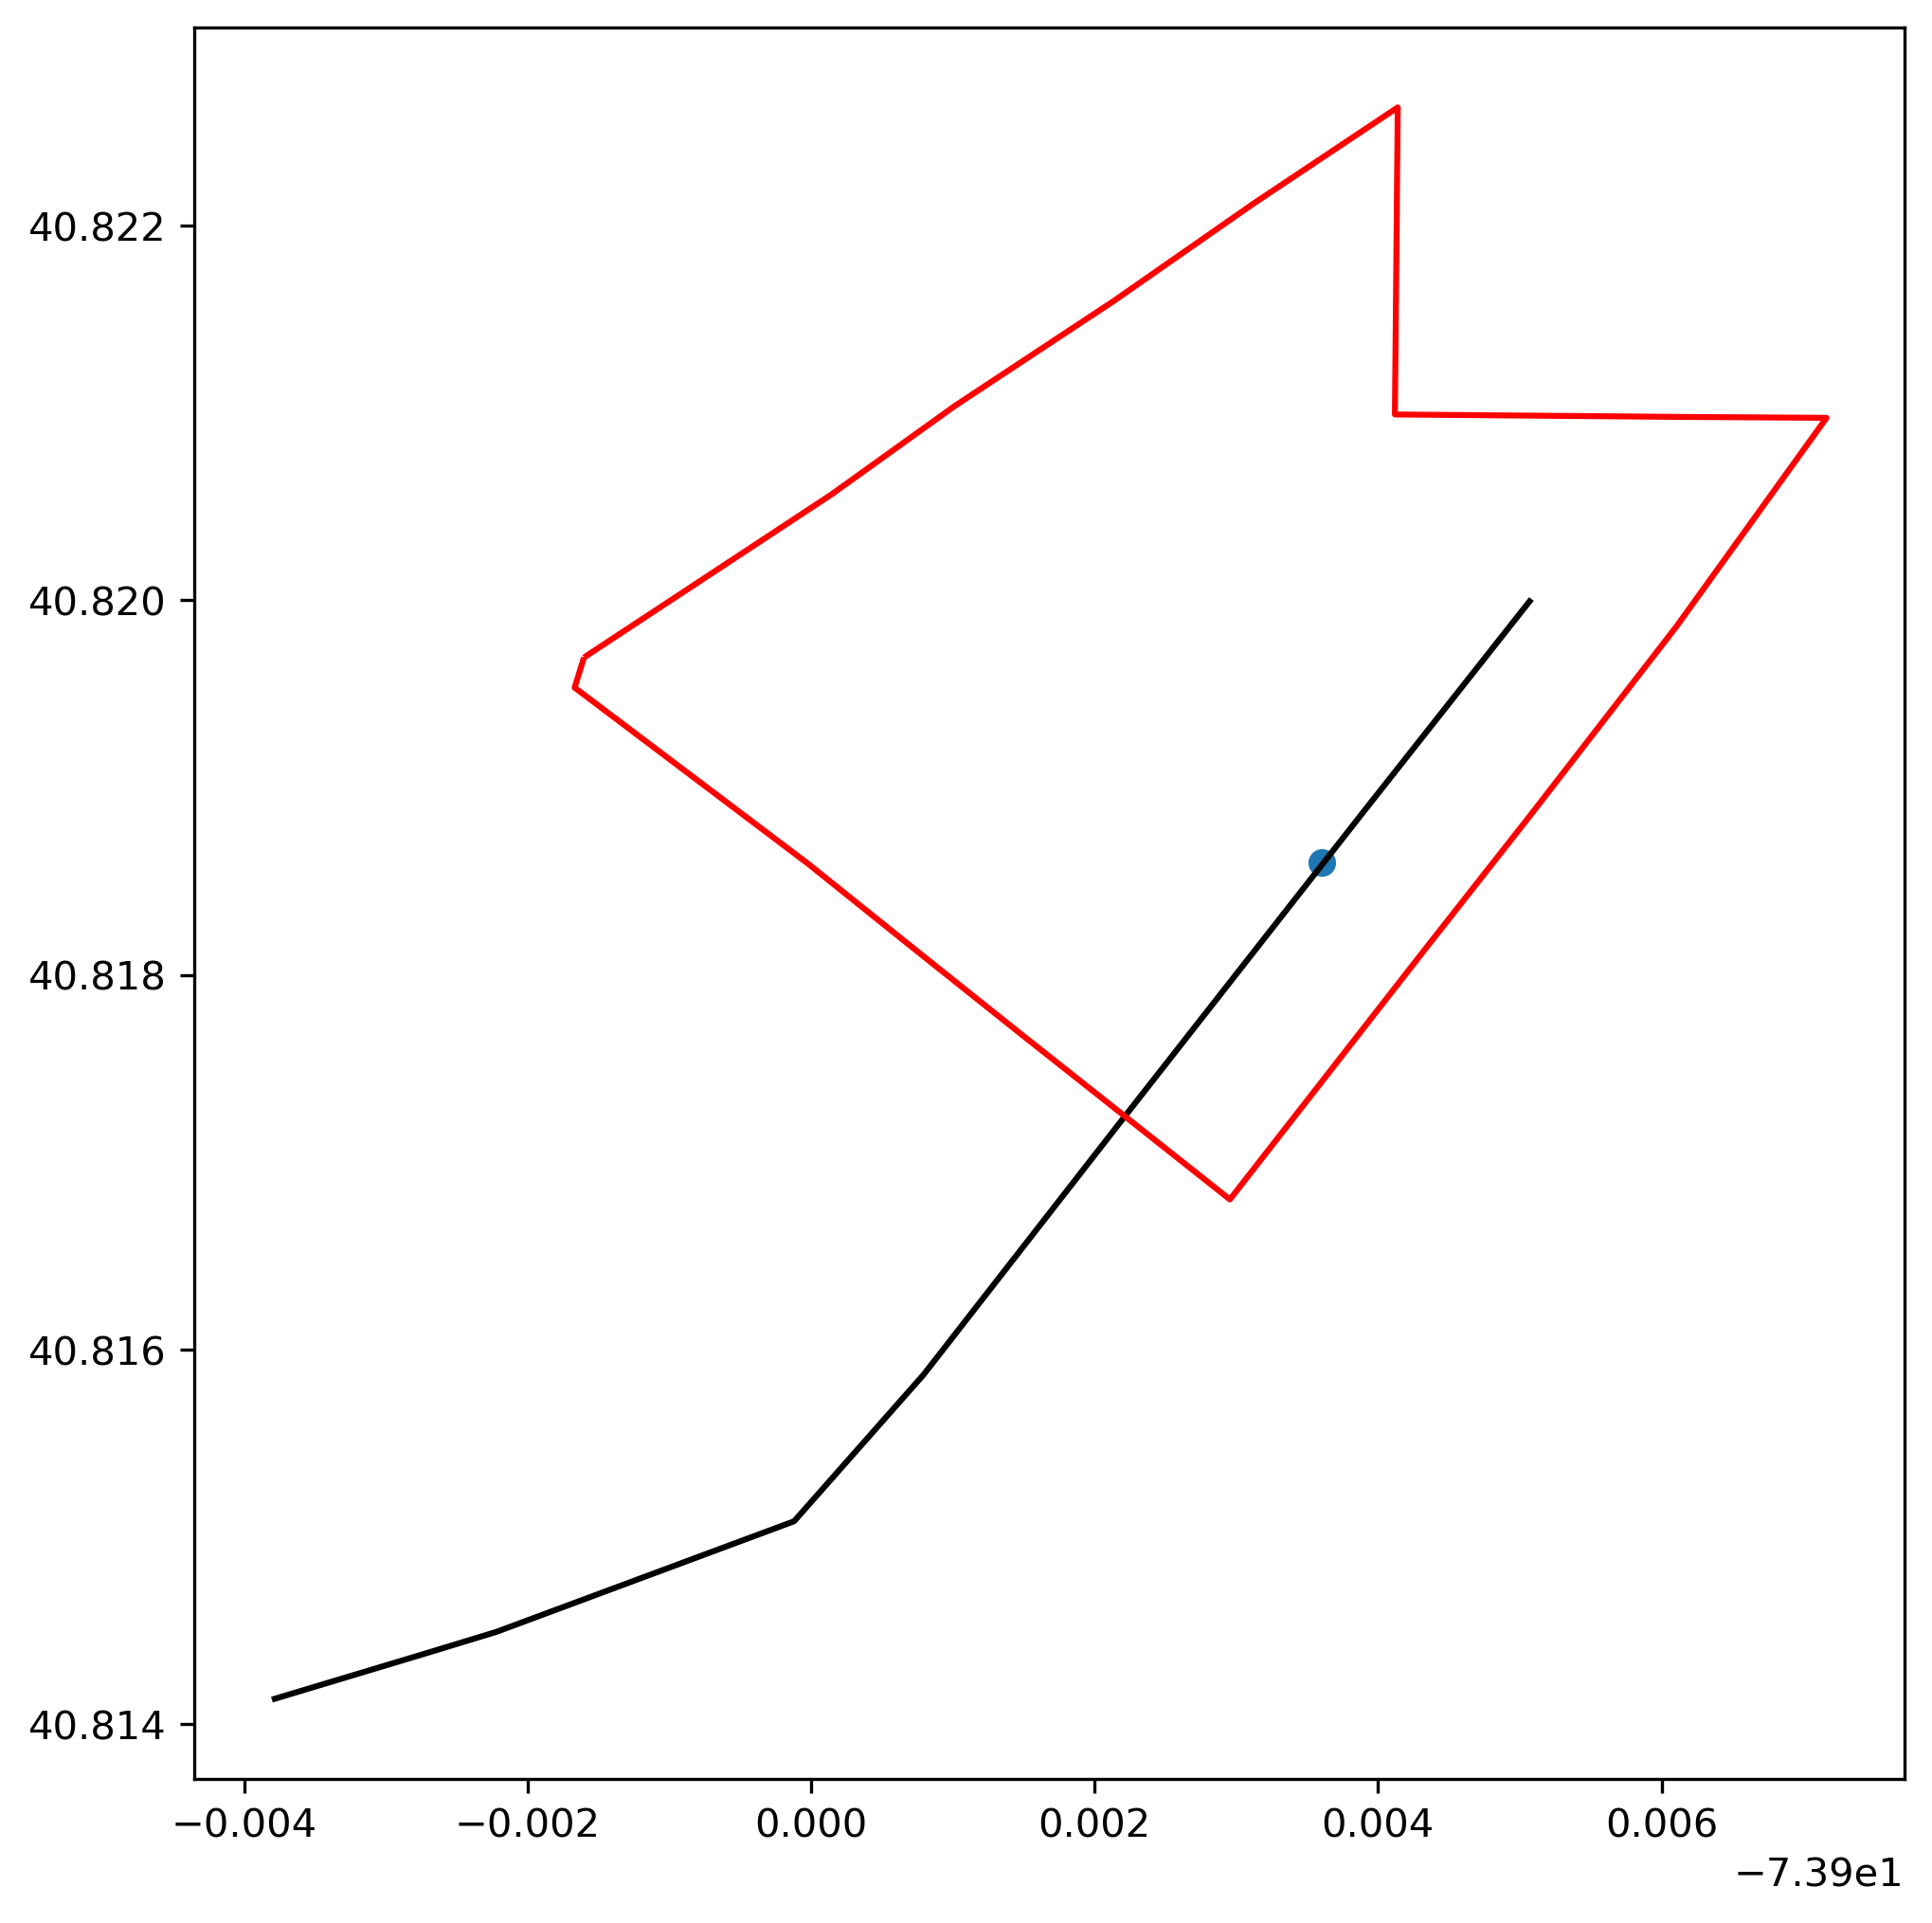

In [7]:
# === Incidences Rank 0 -> Rank 1 (used also as incidence(0, 1)) ====
edges_pts_road = []
for i, j in enumerate(map_0_1):
    if j is not None:
        edges_pts_road.append([i, j])

# === Incidences Rank 1 -> Rank 2 ====
# strategy: create neighbors if they road and tract share a point
edges_road_tract = []
for i, road in enumerate(cell_1):
    for k, tract in enumerate(cell_2):
        if set(road) & set(tract):
            edges_road_tract.append([i, k])

# map a point tract and road to verify
n = 1000
pt_n = pts.iloc[[n]]
road_n = roads.iloc[pt_n.road]
tract_n = tracts.iloc[pt_n.tract]
fig, ax = plt.subplots()
pt_n.plot(ax=ax)
road_n.plot(ax=ax, color="black")
tract_n.boundary.plot(ax=ax, color="red")

<Axes: >

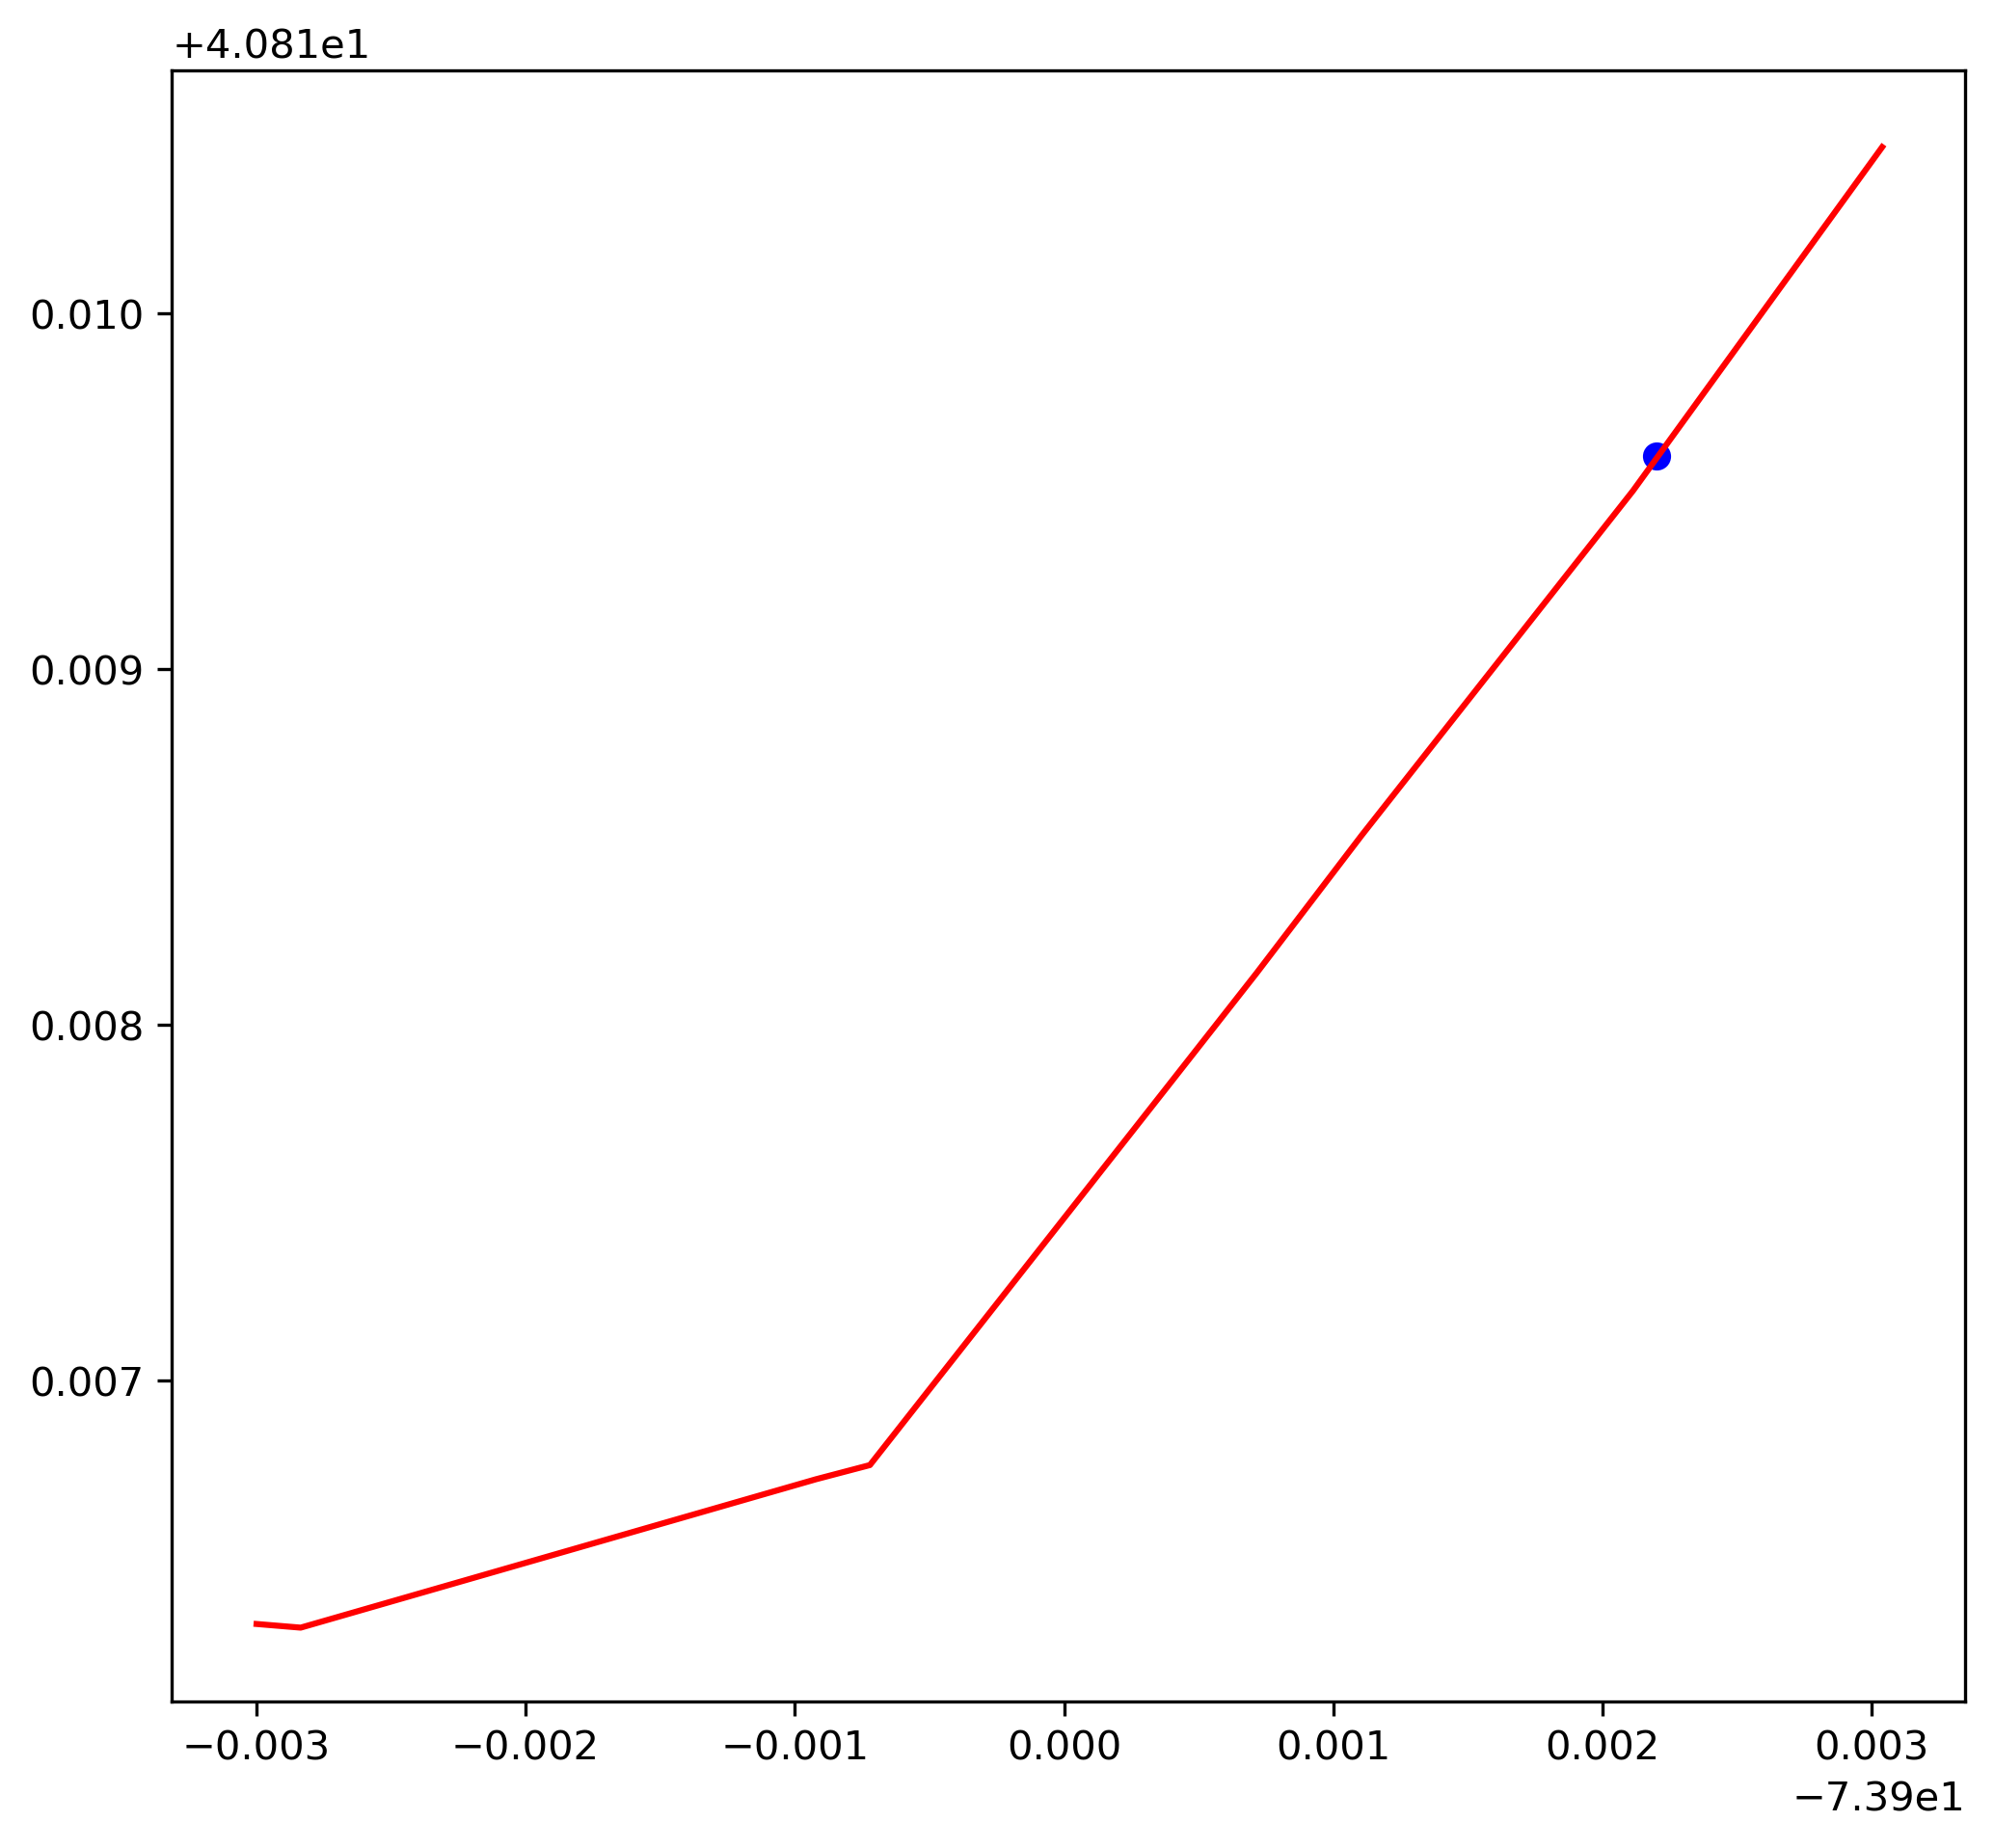

In [8]:
fig, ax = plt.subplots()
pt_n = 7
tgts = [e[1] for e in edges_pts_road if e[0] == pt_n]
p = pts.iloc[[pt_n]]
r = roads.iloc[tgts]
p.plot(ax=ax, color="blue")
r.plot(ax=ax, color="red")

<Axes: >

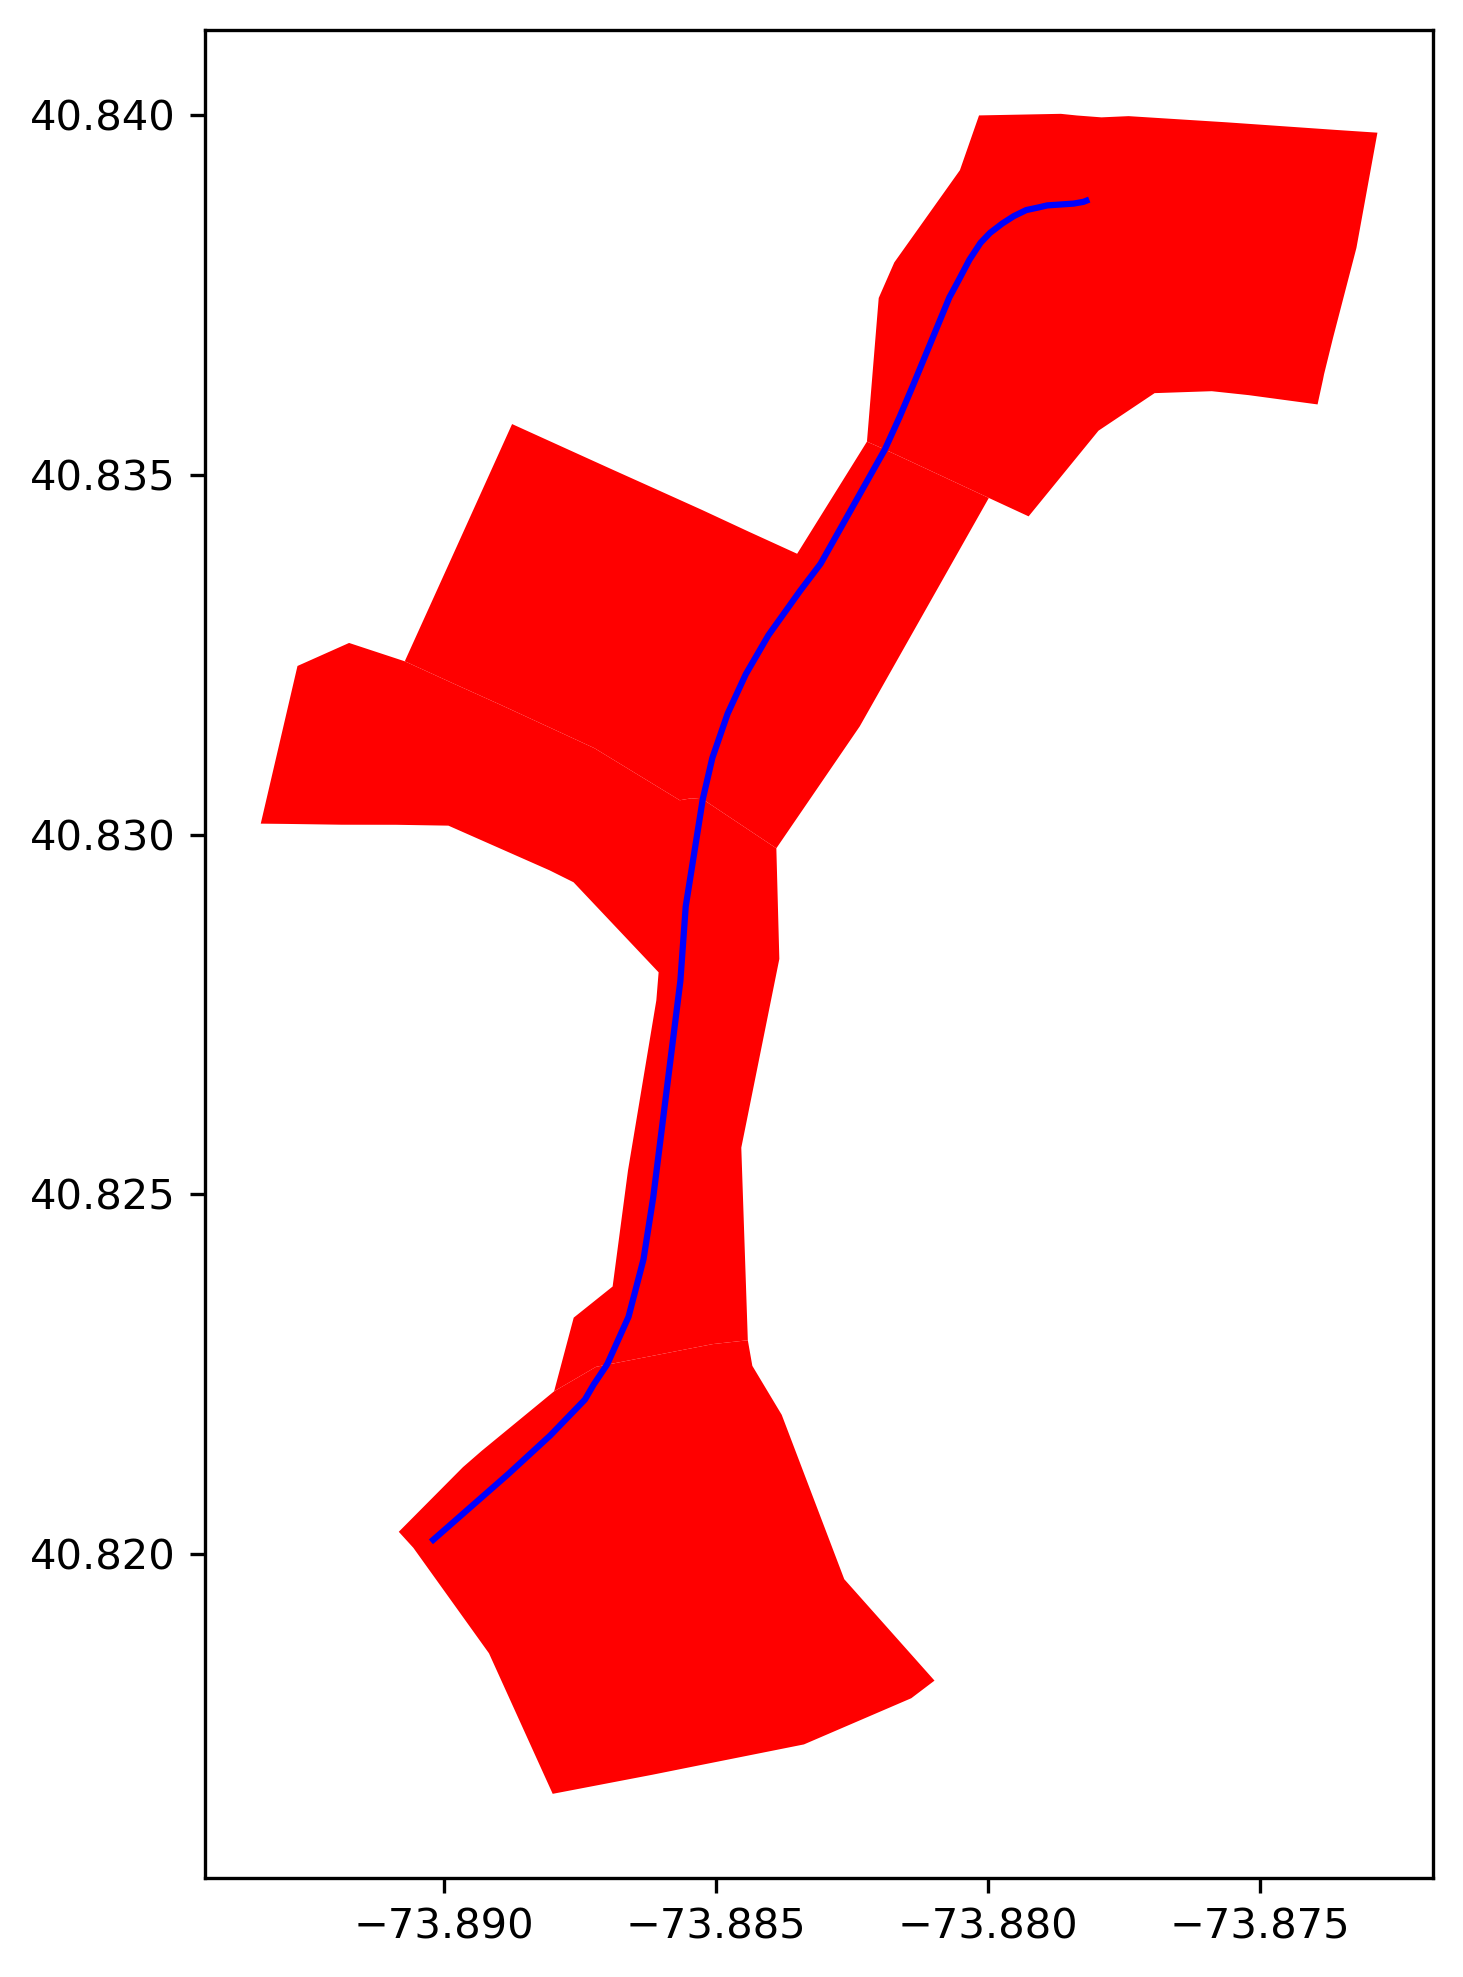

In [9]:
fig, ax = plt.subplots()
r_n = 7
tgts = [e[1] for e in edges_road_tract if e[0] == pt_n]
p = roads.iloc[[r_n]]
r = tracts.iloc[tgts]
p.plot(ax=ax, color="blue")
r.plot(ax=ax, color="red")

/var/folders/h3/2f91vbwj7r506n1w06610njh0000gn/T/ipykernel_91100/3213064938.py:21: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  nbr_tracts.plot(
/var/folders/h3/2f91vbwj7r506n1w06610njh0000gn/T/ipykernel_91100/3213064938.py:29: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  nbr_tracts.plot(


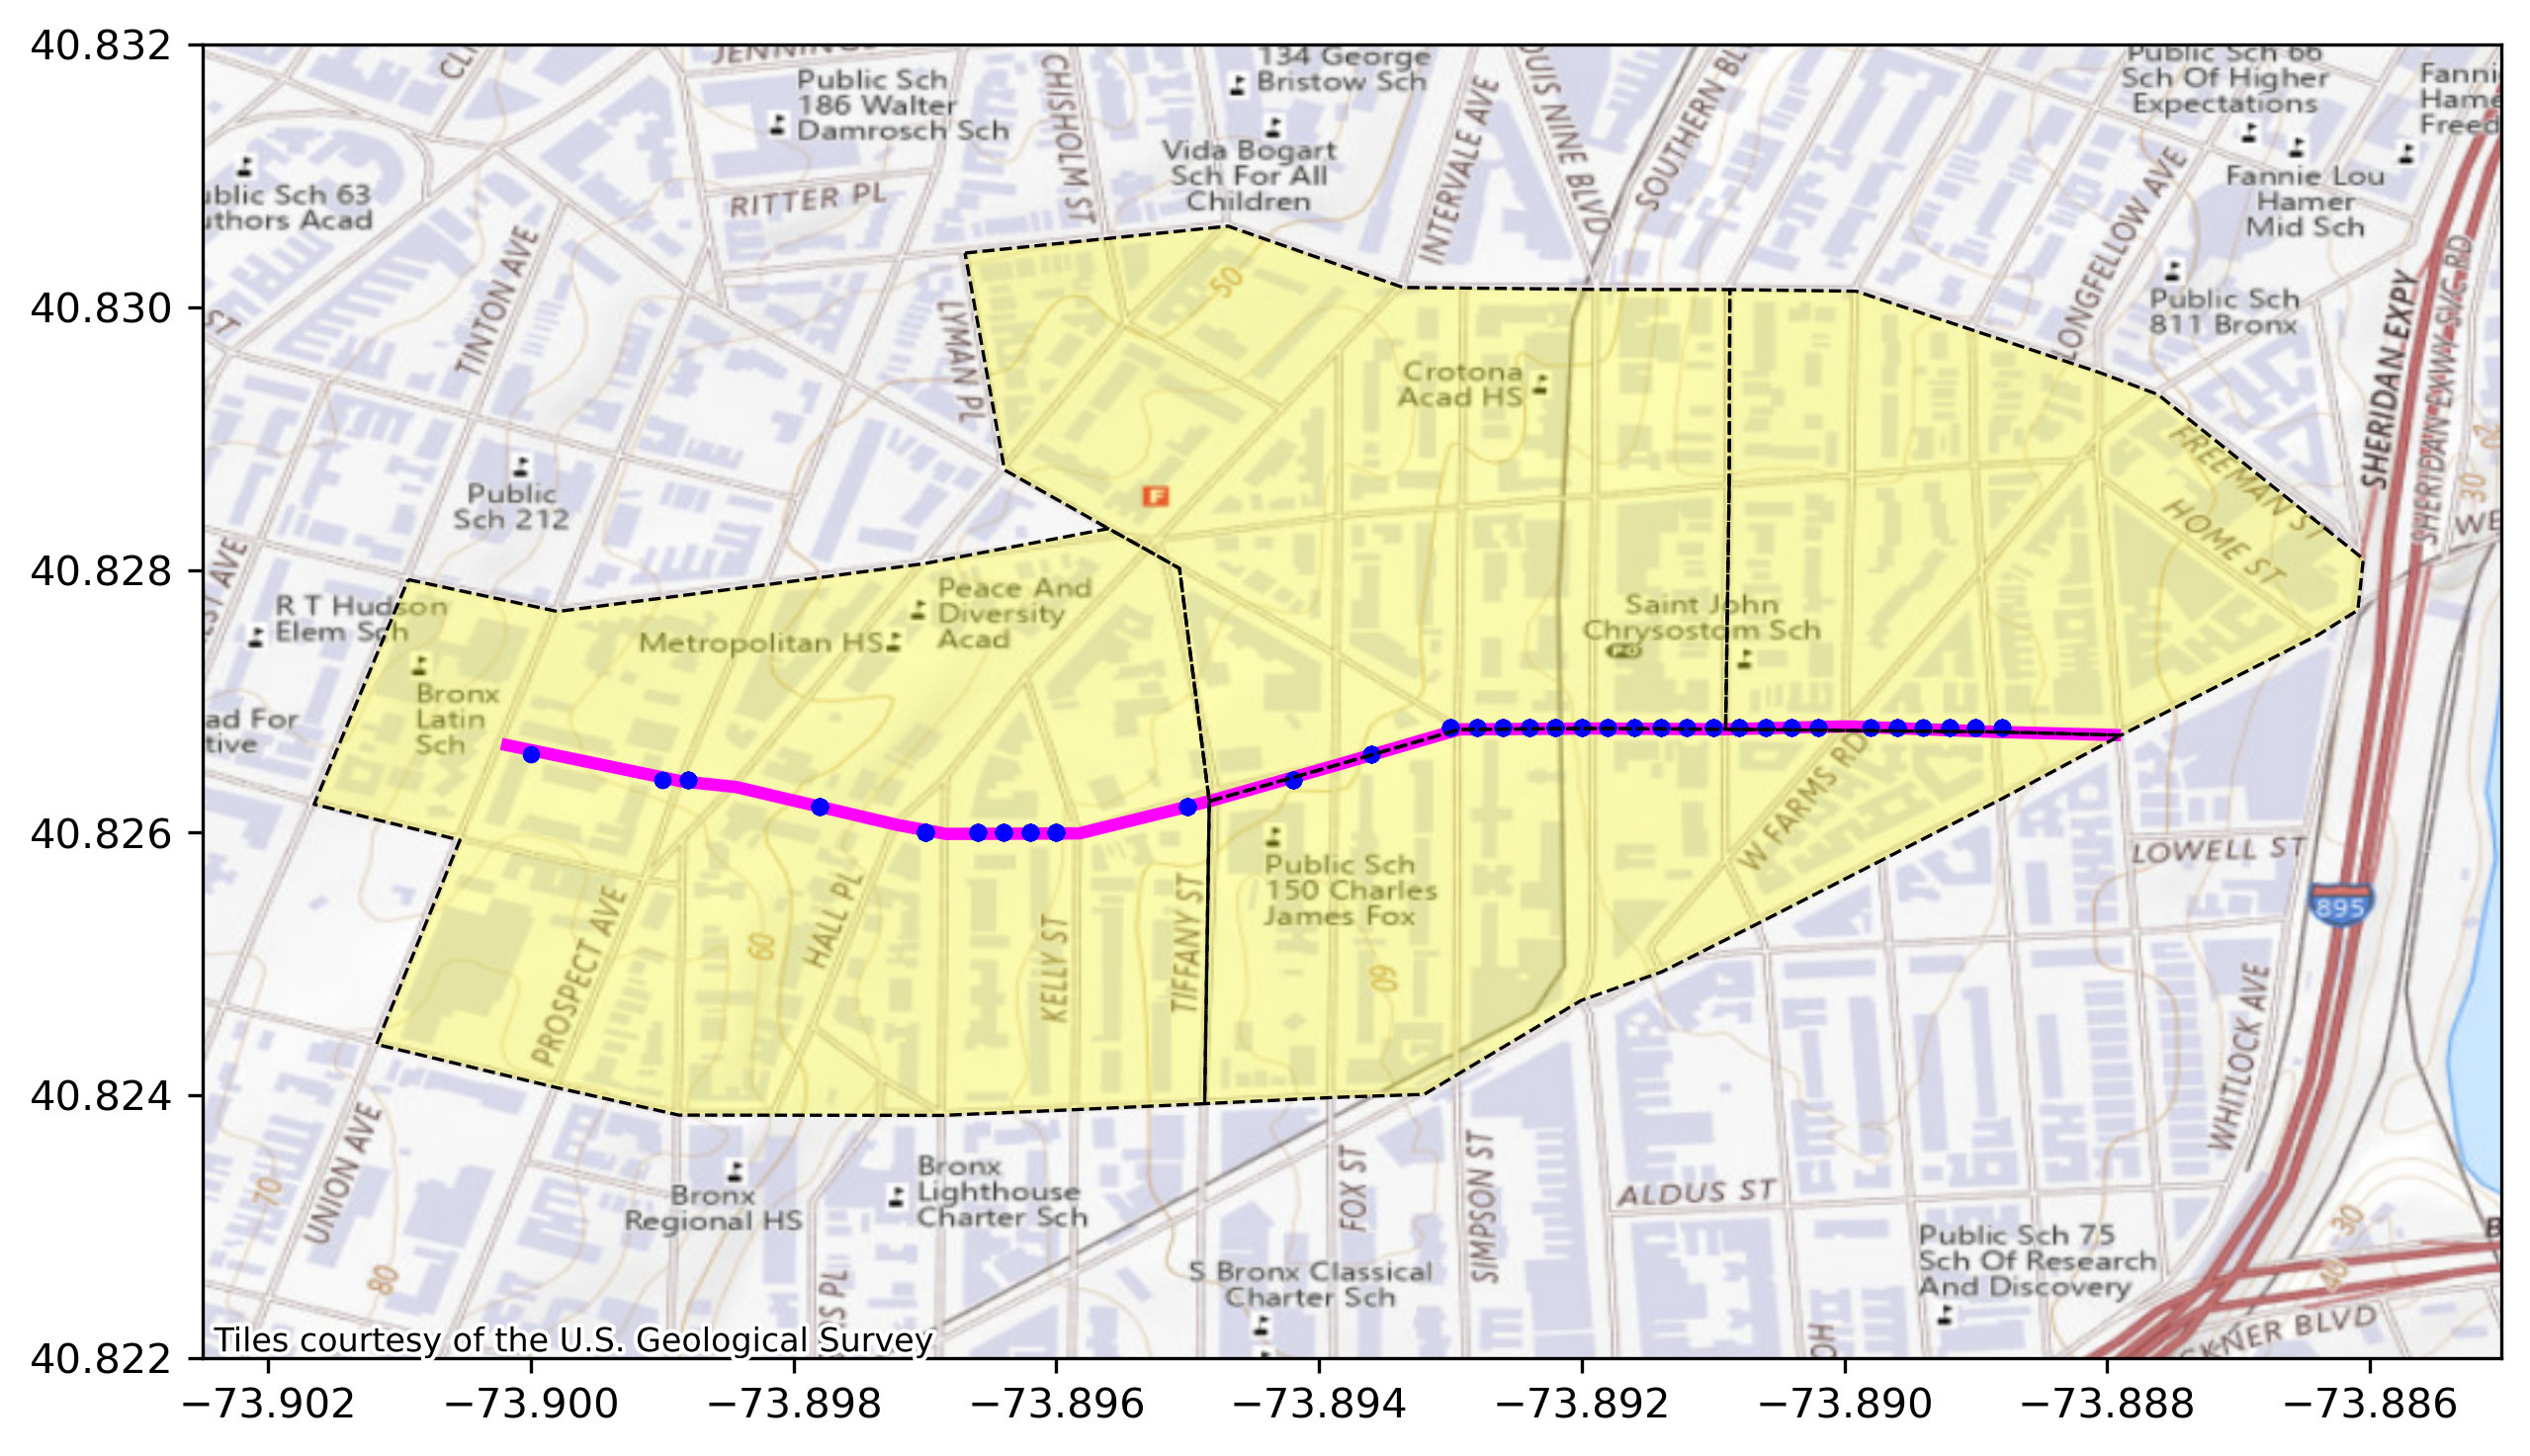

<Axes: >

In [10]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

#
road_counts = pd.Series([e[1] for e in edges_pts_road])
vc = road_counts.value_counts()
vc_k = vc.index[13]

#
tgt_pts = [e[0] for e in edges_pts_road if e[1] == vc_k]
tgt_roads = [vc_k]
tgt_tracts = [e[1] for e in edges_road_tract if e[0] == vc_k]


# Show an example
pts_k = pts.iloc[tgt_pts]
road_feats_k = roads.iloc[tgt_roads]
nbr_tracts = tracts.iloc[tgt_tracts]

# roads.plot(ax=ax, color="black", alpha=0.1)
# make fill collor always yello
nbr_tracts.plot(
    "id",
    alpha=0.3,
    lw=0.0,
    ls="--",
    color="yellow",
    ax=ax,
)
nbr_tracts.plot(
    "id",
    edgecolor="black",
    ls="--",
    alpha=1.0,
    lw=0.8,
    color="none",
    ax=ax,
    zorder=11
)
road_feats_k.plot(color="magenta", linewidth=3, ax=ax)
# ensure pts appear on top of other plots
pts_k.plot(markersize=10, ax=ax, c="blue", zorder=10)

# plt.title("Example of road intersecting tracts")


# make sure that the axis coordinates do not use scientific notation
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.get_yaxis().get_major_formatter().set_useOffset(False)
plt.xlim(-73.9025, -73.885)
plt.ylim(40.822, 40.832)
cx.add_basemap(ax, crs=tracts.crs, zoom=16, source=cx.providers.USGS.USTopo)
plt.show()

# save as png
fig.savefig("notebooks/spatial-cc-example.png", bbox_inches="tight")
ax

### Points

Visualize points/pm25

SensorID                      time      lon      lat  temperature  \
0      NYCP2_CS03A 2021-12-14 14:20:00-05:00 -73.8930  40.8144         13.1   
1      NYCP2_CS03A 2021-12-14 14:20:00-05:00 -73.8920  40.8138         13.2   
2      NYCP2_CS03A 2021-12-14 14:20:00-05:00 -73.8912  40.8138         13.2   
3      NYCP2_CS01A 2021-09-10 08:45:00-04:00 -73.8696  40.8474         22.3   
4      NYCP2_CS03A 2021-12-14 14:20:00-05:00 -73.8910  40.8138         13.1   
...            ...                       ...      ...      ...          ...   
58718  NYCP2_CS03A 2021-12-14 14:20:00-05:00 -73.8990  40.8184         12.8   
58719  NYCP2_CS03A 2021-12-14 14:20:00-05:00 -73.8986  40.8188         12.7   
58720  NYCP2_CS03A 2021-12-14 14:20:00-05:00 -73.8960  40.8162         13.1   
58721  NYCP2_CS03A 2021-12-14 14:20:00-05:00 -73.8950  40.8158         13.1   
58722  NYCP2_CS03A 2021-12-14 14:20:00-05:00 -73.8940  40.8150         13.0   

       humidity      pm25                    geometry  road  tract  
0          24.7  3.270198  POINT (-73.89300 40.81440)    32     11  
1          25.0  3.210435  POINT (-73.89200 40.81380)    32     11  
2          25.7  3.399750  POINT (-73.89120 40.81380)   407     12  
3          60.0  5.878183  POINT (-73.86960 40.84740)     0      0  
4          26.0  3.447514  POINT (-73.89100 40.81380)   407     12  
...         ...       ...                         ...   ...    ...  
58718      24.5  3.210435  POINT (-73.89900 40.81840)   107     44  
58719      24.9  3.212317  POINT (-73.89860 40.81880)   107     44  
58720      24.4  3.210435  POINT (-73.89600 40.81620)    32     38  
58721      24.6  3.210435  POINT (-73.89500 40.81580)    19     12  
58722      24.5  3.210435  POINT (-73.89400 40.81500)   354     11  

[58723 rows x 10 columns]

<Axes: >

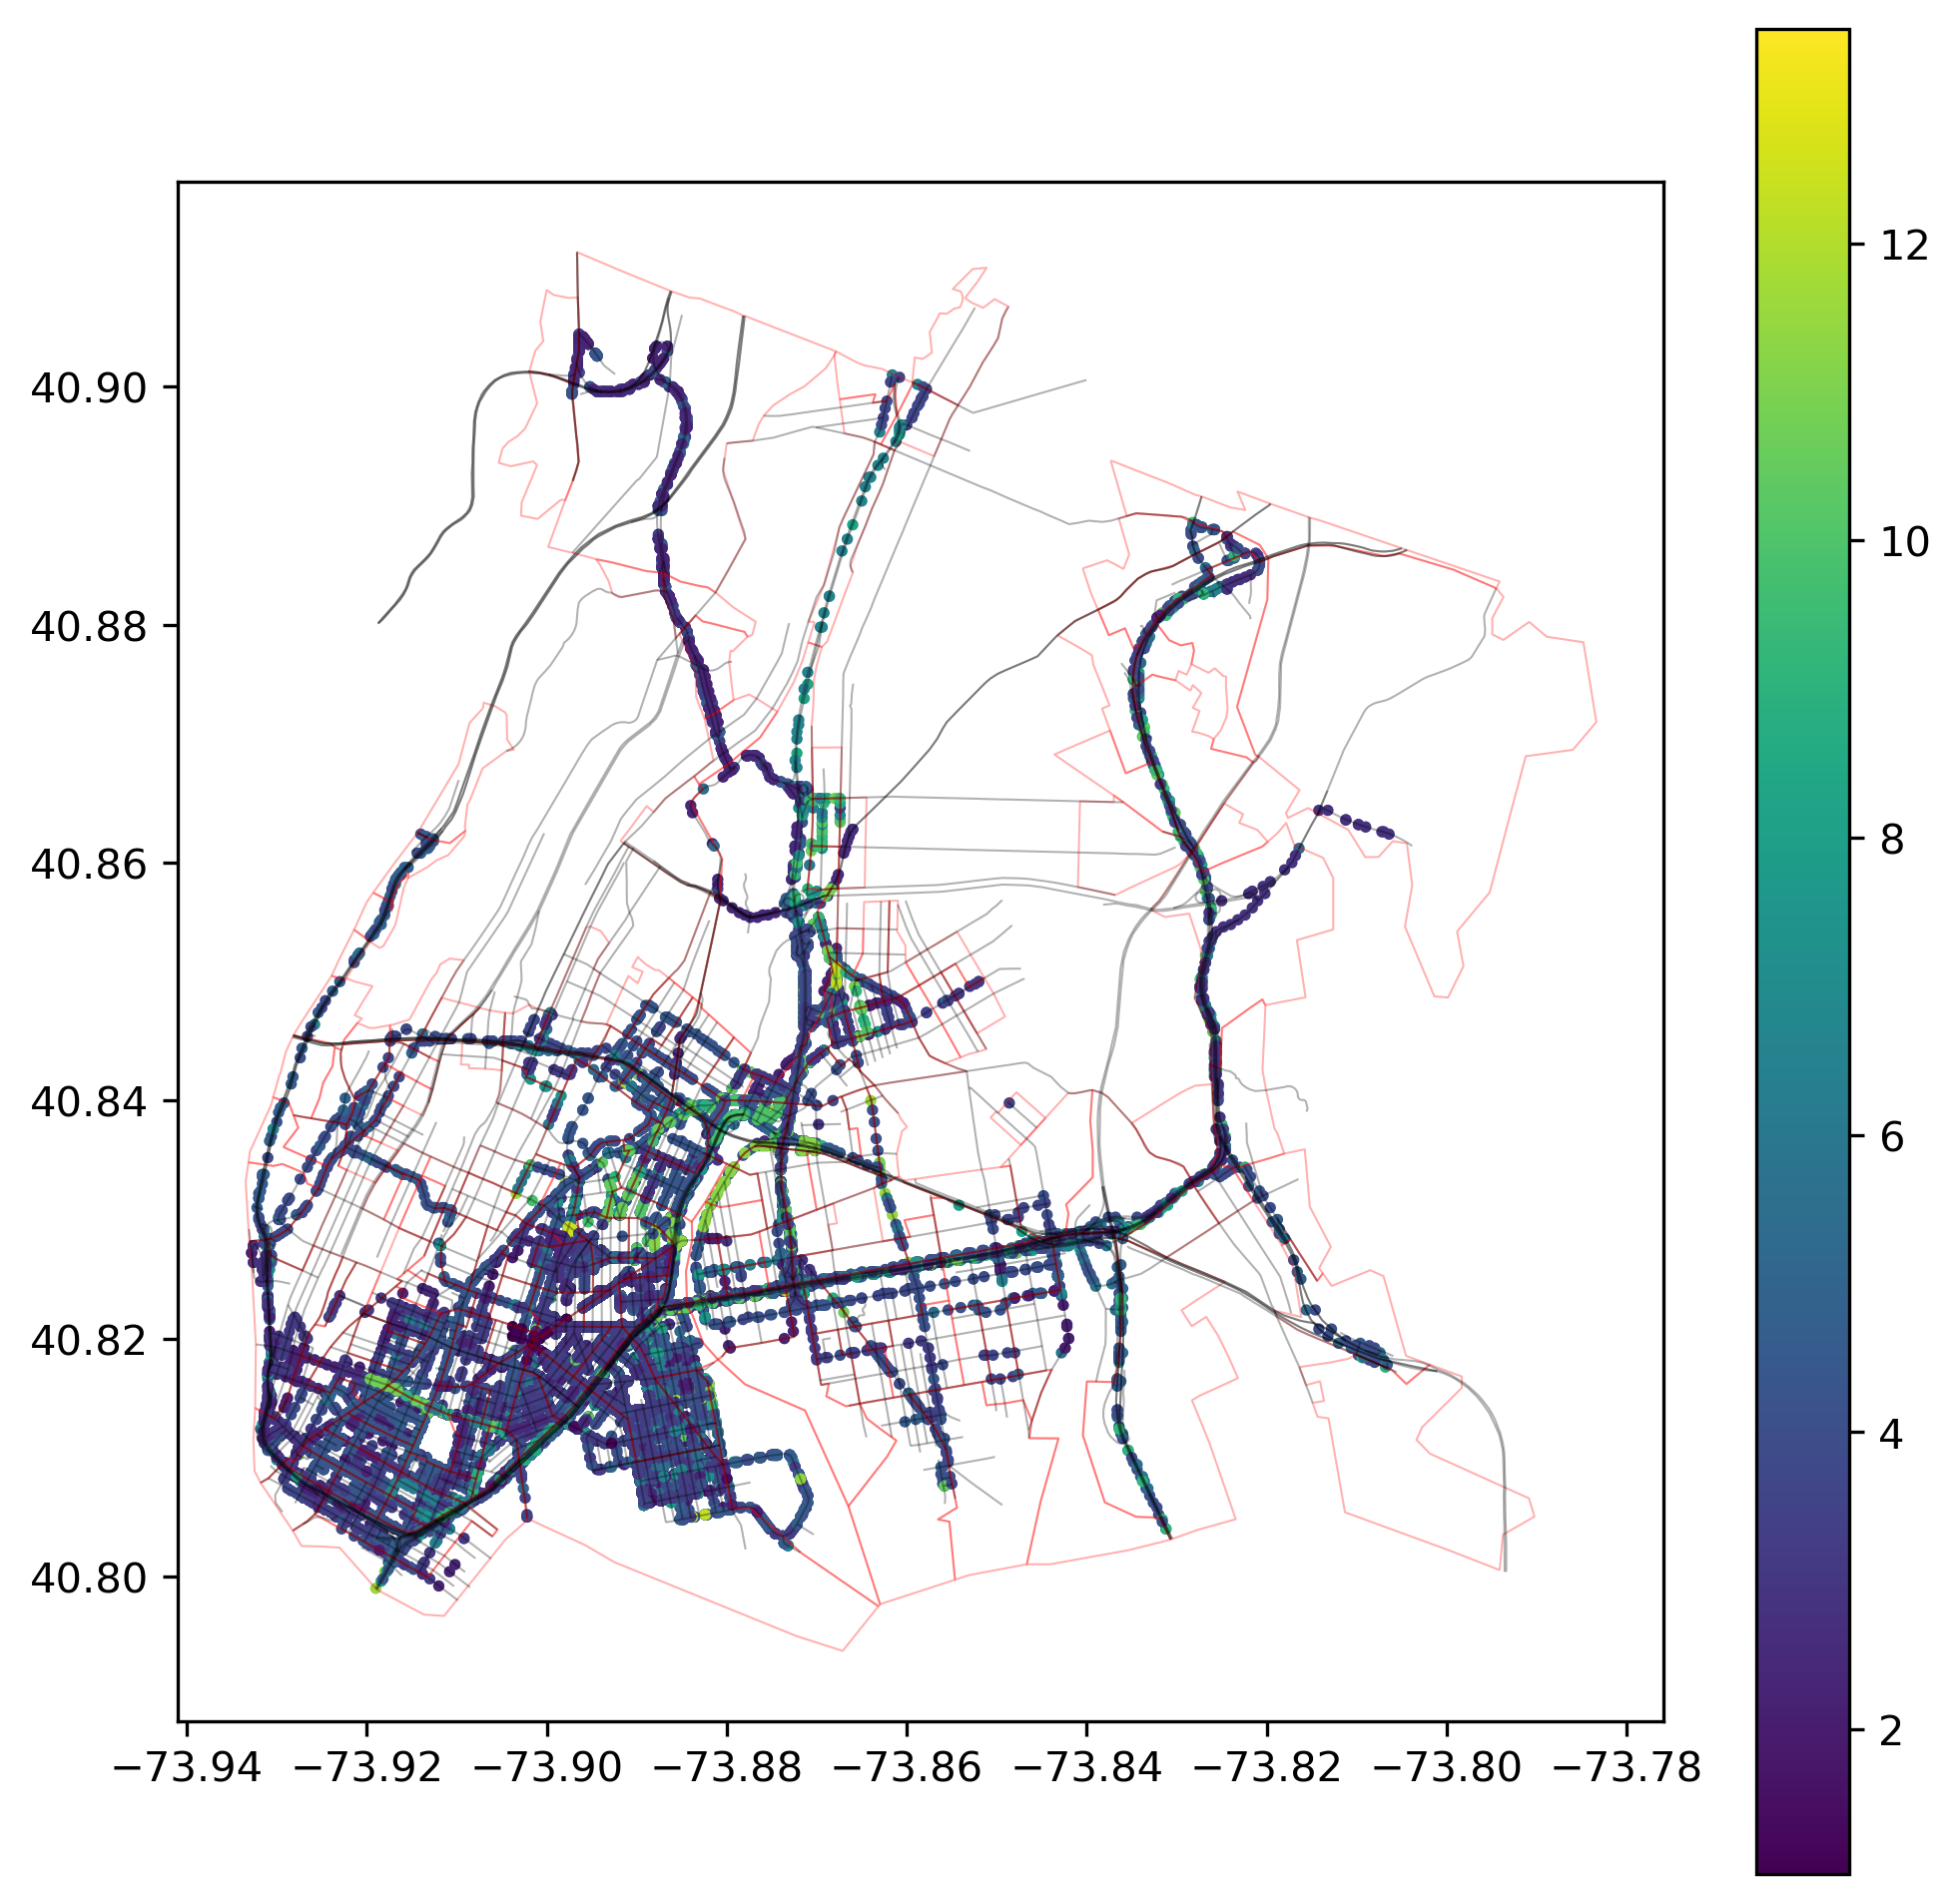

In [11]:
display(pts)
fig, ax = plt.subplots()
tracts.boundary.plot(edgecolor="red", linewidth=0.5, alpha=0.3, ax=ax)
roads.plot(color="black", linewidth=0.5, alpha=0.3, ax=ax)
pts.plot("pm25", legend=True, markersize=3, ax=ax)

Text(0.5, 1.0, 'Count of points per road')

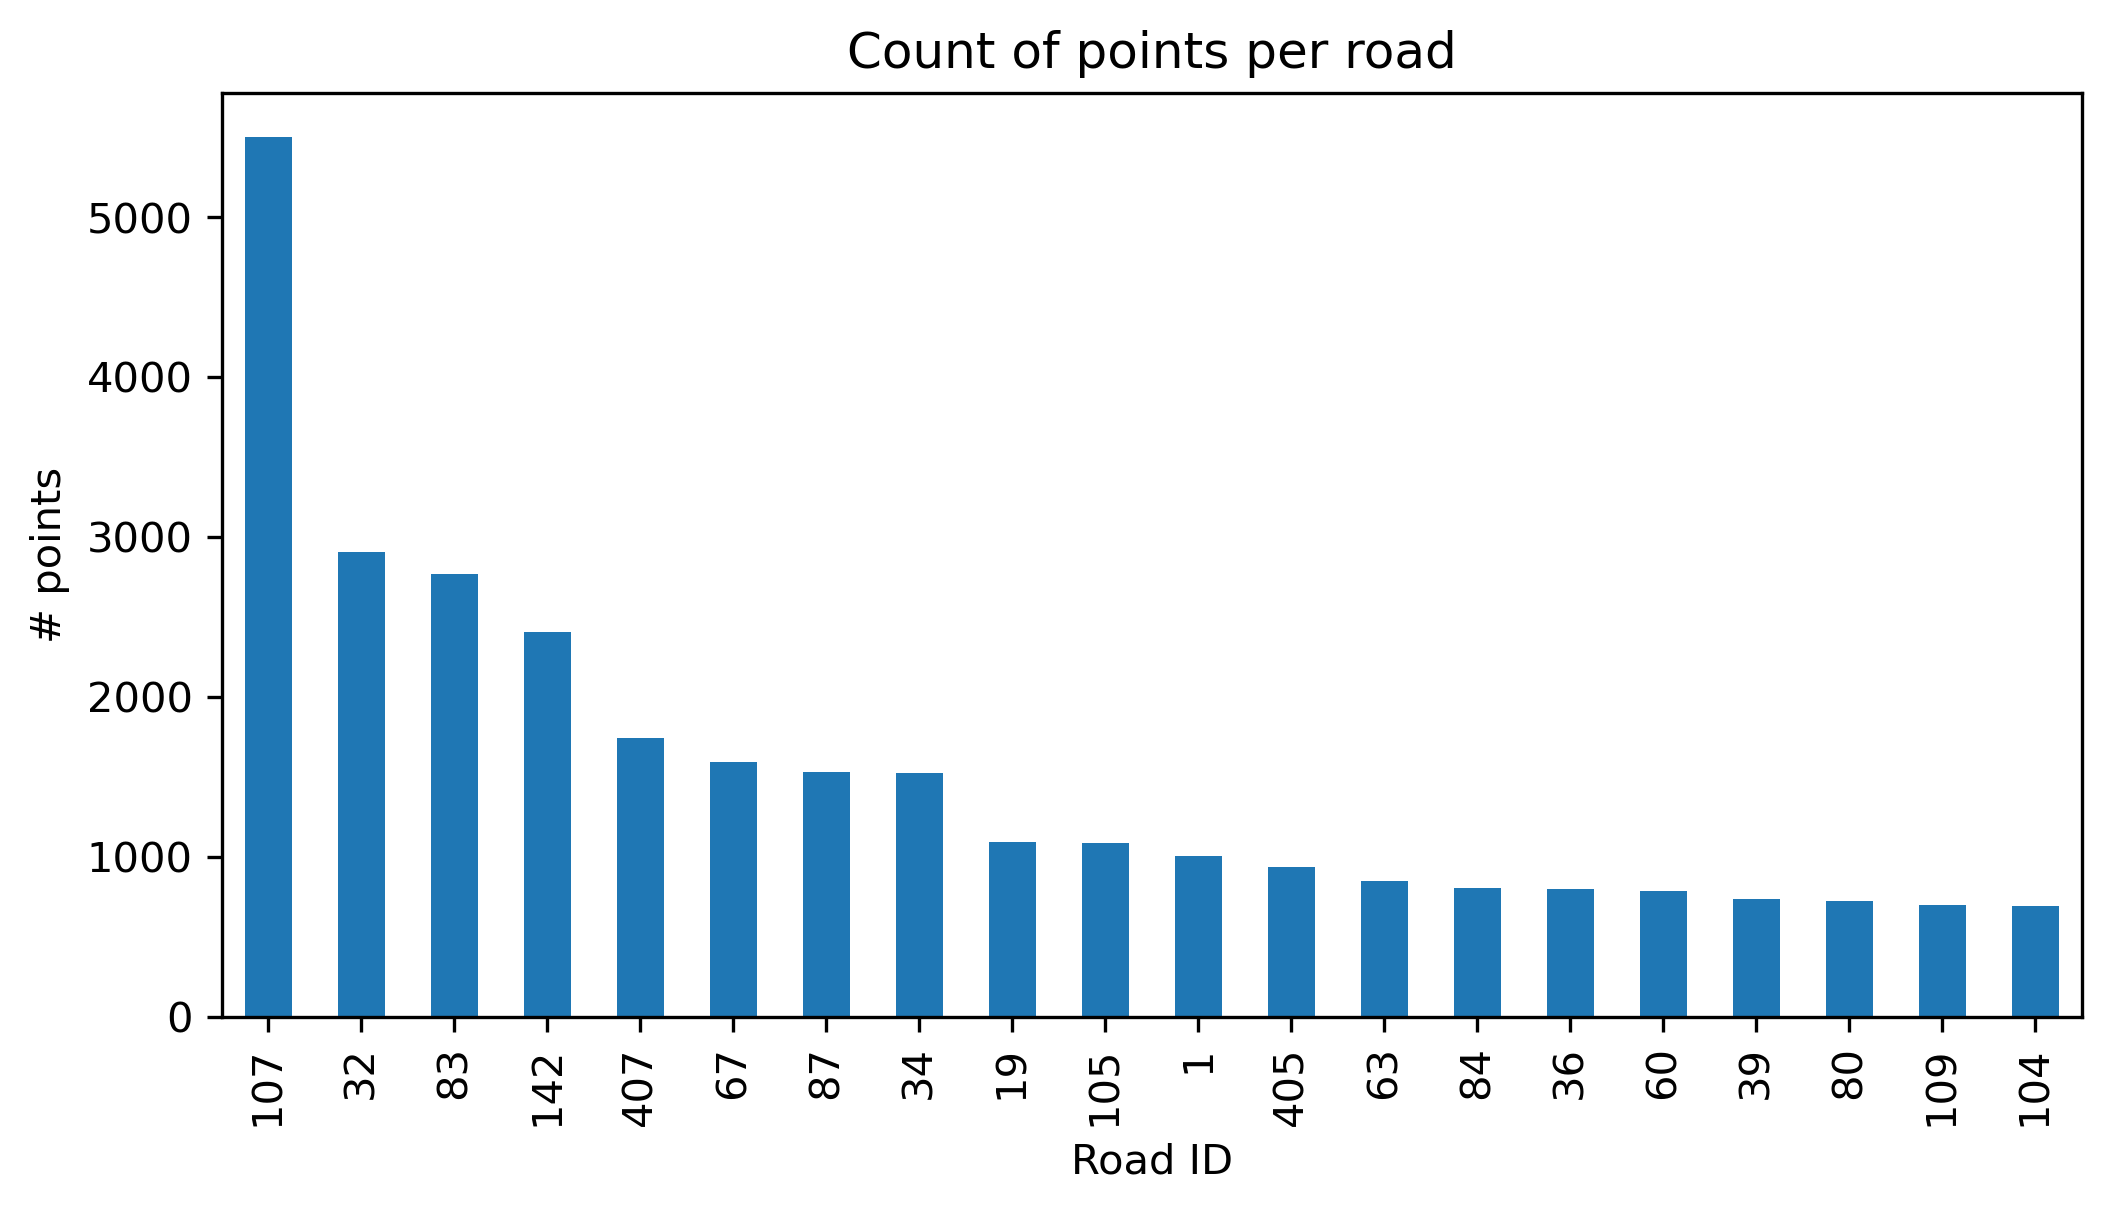

In [12]:
fig, ax = plt.subplots(figsize=[8, 4])
pts.road.value_counts().iloc[:20].plot(kind="bar", ax=ax)
plt.xlabel("Road ID")
plt.ylabel("# points")
plt.title("Count of points per road")


Separate point features matrix

In [13]:
pts_feats = pts.copy()
# compute time as fraction of day
pts_feats["weekday"] = pts_feats.time.dt.weekday
pts_feats["time_of_day"] =( pts_feats.time.dt.hour + pts_feats.time.dt.minute / 60) / 24
y = pts_feats[["pm25", "geometry"]]
pts_feats = pts_feats.drop(columns=["SensorID", "road", "tract", "lon", "lat", "time", "pm25"])
# replace weekday with one-hot encoding
pts_feats = pd.get_dummies(pts_feats, columns=["weekday"], drop_first=True)

Point features

In [14]:
display(pts_feats)

temperature  humidity                    geometry  time_of_day  \
0             13.1      24.7  POINT (-73.89300 40.81440)     0.597222   
1             13.2      25.0  POINT (-73.89200 40.81380)     0.597222   
2             13.2      25.7  POINT (-73.89120 40.81380)     0.597222   
3             22.3      60.0  POINT (-73.86960 40.84740)     0.364583   
4             13.1      26.0  POINT (-73.89100 40.81380)     0.597222   
...            ...       ...                         ...          ...   
58718         12.8      24.5  POINT (-73.89900 40.81840)     0.597222   
58719         12.7      24.9  POINT (-73.89860 40.81880)     0.597222   
58720         13.1      24.4  POINT (-73.89600 40.81620)     0.597222   
58721         13.1      24.6  POINT (-73.89500 40.81580)     0.597222   
58722         13.0      24.5  POINT (-73.89400 40.81500)     0.597222   

       weekday_1  weekday_2  weekday_3  weekday_4  weekday_5  weekday_6  
0           True      False      False      False      False      False  
1           True      False      False      False      False      False  
2           True      False      False      False      False      False  
3          False      False      False       True      False      False  
4           True      False      False      False      False      False  
...          ...        ...        ...        ...        ...        ...  
58718       True      False      False      False      False      False  
58719       True      False      False      False      False      False  
58720       True      False      False      False      False      False  
58721       True      False      False      False      False      False  
58722       True      False      False      False      False      False  

[58723 rows x 10 columns]

Labels=y at the rank 0 level

In [15]:
display(y)

pm25                    geometry
0      3.270198  POINT (-73.89300 40.81440)
1      3.210435  POINT (-73.89200 40.81380)
2      3.399750  POINT (-73.89120 40.81380)
3      5.878183  POINT (-73.86960 40.84740)
4      3.447514  POINT (-73.89100 40.81380)
...         ...                         ...
58718  3.210435  POINT (-73.89900 40.81840)
58719  3.212317  POINT (-73.89860 40.81880)
58720  3.210435  POINT (-73.89600 40.81620)
58721  3.210435  POINT (-73.89500 40.81580)
58722  3.210435  POINT (-73.89400 40.81500)

[58723 rows x 2 columns]

### Road traffic level features

Columns: id, name, desc, county, route, fromMile, toMile, fc, latitude, longitude, AADT_2022, AAWDT_2022, PCT_2022, AADT_2021, AAWDT_2021, PCT_2021, AADT_2020, AAWDT_2020, PCT_2020, AADT_2019, AAWDT_2019, PCT_2019, AADT_2018, AAWDT_2018, PCT_2018, AADT_2017, AAWDT_2017, PCT_2017, AADT_2016, AAWDT_2016, PCT_2016, AADT_2015, AAWDT_2015, PCT_2015, AADT_2014, AAWDT_2014, PCT_2014, AADT_2013, AAWDT_2013, PCT_2013, geometry


id            name  \
0      010001000000          010001   
1      010002000000          010002   
2      010003000000            0191   
3      01000300000R  0199 (RETIRED)   
4      010004000000          010004   
...             ...             ...   
55815  978034000000          978034   
55816  978036000000          978036   
55817  978037000000          978037   
55818  978501000000          978501   
55819  978608000000          978608   

                                                    desc county  \
0      I-95 from NY/Bronx Co Line to I-87 MAJ DEEGAN ...  Bronx   
1      I-95 from I-87 MAJ DEEGAN EXP UNDER to MACOMBS...  Bronx   
2                              239 FT West of Jerome Ave   None   
3         I-95 from MACOMBS RD OVER to END I-95/US1 OLAP  Bronx   
4                             US1 from END I-95/US1 OLAP  Bronx   
...                                                  ...    ...   
55815       CR43 GOODRICH RD from NY 17C to GLEN MARY DR  Tioga   
55816  CR17 BERRY ROAD from HUNTS CREEK RD RD to STAN...  Tioga   
55817         N ELLISTOWN RD from BROAD ST EXT to NY 17C  Tioga   
55818  CR3 DEAN CREEK RD from EDGECOMB HILL RD to SPE...  Tioga   
55819  CR7 HALSEY VALLEY R from BARTON T/L to SPENCER...  Tioga   

                 route fromMile toMile                                     fc  \
0      ALEXANDER HAMIL        0   0.07  Urban:Principal Arterial - Interstate   
1      CROSS BRONX EXP     0.07   0.58  Urban:Principal Arterial - Interstate   
2                 None     None   None     LU:Principal Arterial - Interstate   
3      CROSS BRONX EXP     0.58   1.21  Urban:Principal Arterial - Interstate   
4          WEBSTER AVE     1.21   2.71       Urban:Principal Arterial - Other   
...                ...      ...    ...                                    ...   
55815      GOODRICH RD        0   0.53                            Urban:Local   
55816       BERRY ROAD        0   0.77                            Urban:Local   
55817   N ELLISTOWN RD        0   0.33                  Urban:Major Collector   
55818    DEAN CREEK RD     1.43   4.29                            Rural:Local   
55819  HALSEY VALLEY R     8.48   9.37                  Rural:Major Collector   

        latitude   longitude  ... AADT_2015 AAWDT_2015 PCT_2015 AADT_2014  \
0      40.844940  -73.926880  ...      None       None     None      None   
1      40.844880  -73.920390  ...    99,399       None     9.1%   102,658   
2      40.845008  -73.915372  ...   153,360       None    14.8%   162,758   
3      40.844841  -73.906159  ...   153,360       None    14.8%   162,758   
4      40.853662  -73.897180  ...    17,188     18,288     6.1%      None   
...          ...         ...  ...       ...        ...      ...       ...   
55815  42.101200  -76.287090  ...     1,681       None     5.6%     1,700   
55816  42.059350  -76.317980  ...       573       None    11.0%       579   
55817  42.006300  -76.507490  ...     1,720       None     7.5%     1,738   
55818  42.136158  -76.526014  ...      None       None     None      None   
55819  42.148480  -76.444410  ...       766       None     7.7%       682   

      AAWDT_2014 PCT_2014 AADT_2013 AAWDT_2013 PCT_2013  \
0           None     None      None       None     None   
1           None     9.3%   106,024       None     9.2%   
2           None    14.8%   154,510       None    14.8%   
3        143,311    14.8%      None       None     None   
4           None     None      None       None     None   
...          ...      ...       ...        ...      ...   
55815       None     5.6%     1,718      2,040     5.5%   
55816       None    10.9%       586       None    10.9%   
55817      1,749     7.4%     1,867       None     5.9%   
55818       None     None      None       None     None   
55819       None     7.6%       597        617     7.7%   

                         geometry  
0      POINT (-73.92688 40.84494)  
1      POINT (-73.92039 40.84488)  
2      POINT (-73.91537 40.8

Text(0.5, 1.0, 'AADT 2020 in Bronx, NY')

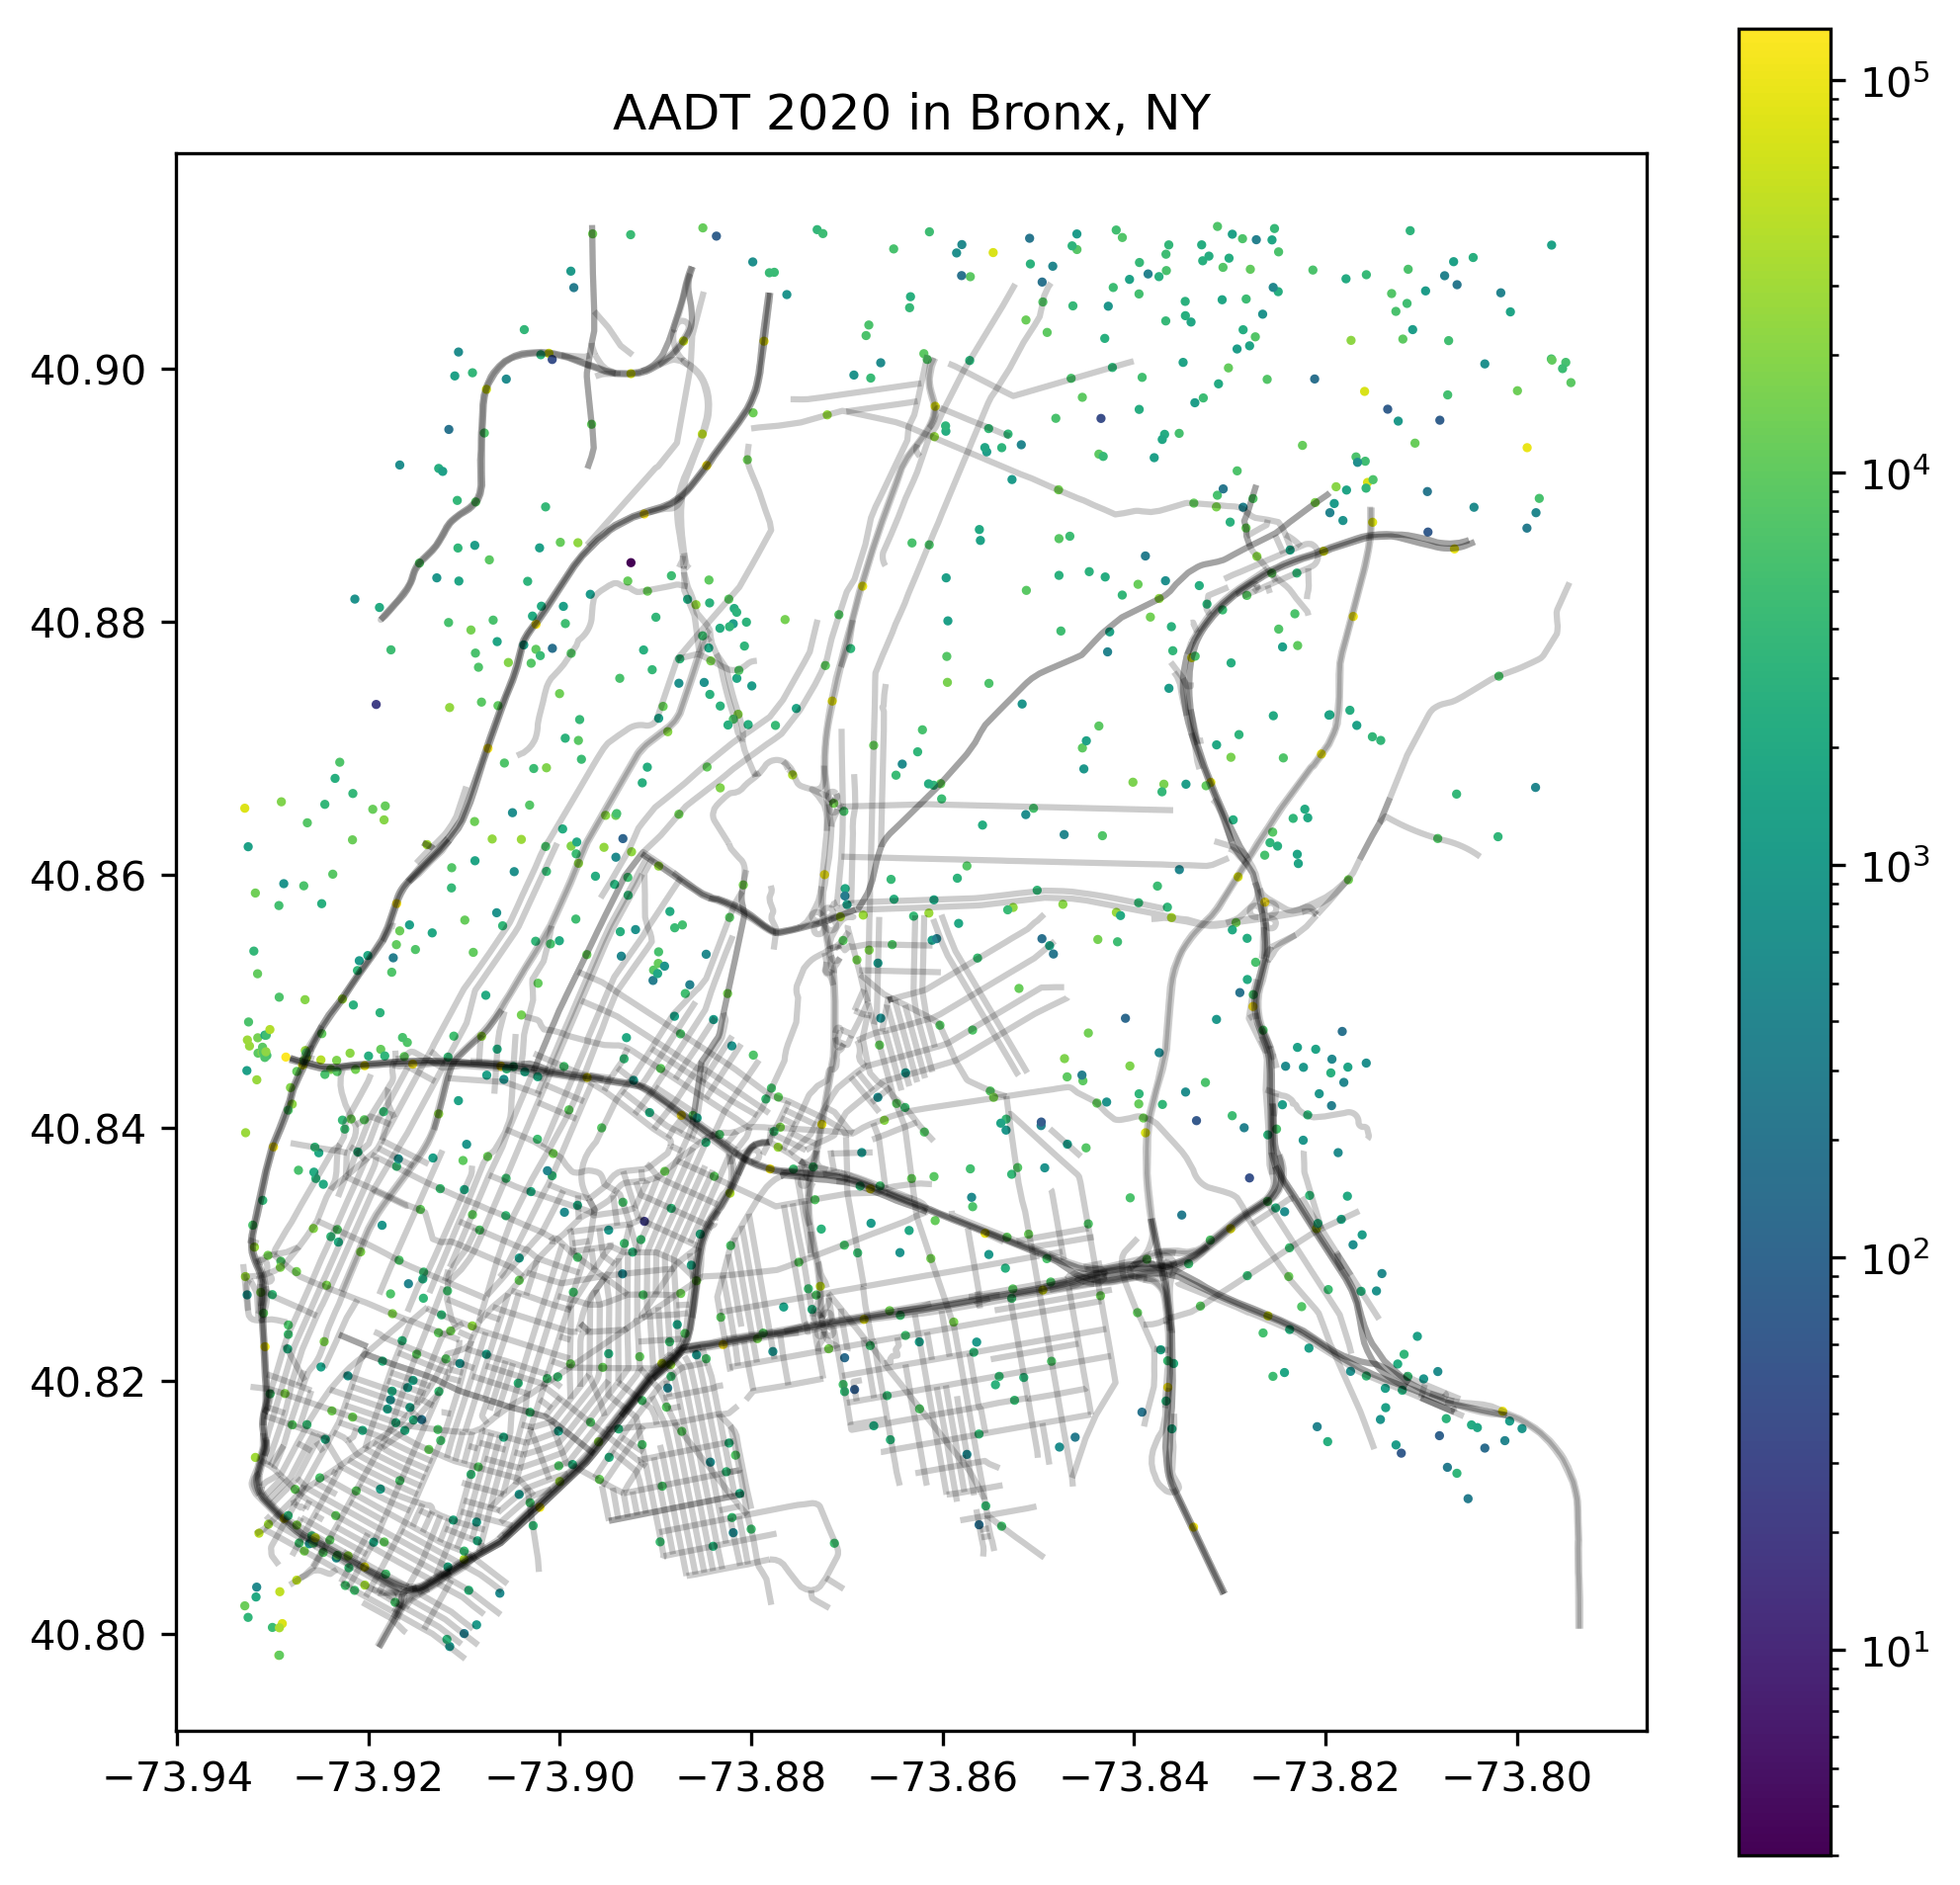

In [16]:
import matplotlib

# load aadt data, crs=2263, used in NYC commonly, convert to WGS84
aadt = gpd.read_file(
    "data/raw/aadt_and_truckpct/features.shp", crs="EPSG:2263"
).to_crs(wgs84)
print("Columns:", ", ".join(aadt.columns))
display(aadt)

# coerce the following vars to numeric, handling comma-separated numbers and % signs
c = ["AADT_2020", "AAWDT_2020", "PCT_2020"]
for col in c:
    aadt[col] = pd.to_numeric(aadt[col].str.replace(",", "").str.replace("%", ""))


# crop to bounds of Bronx
aadt = aadt.cx[
    roads.total_bounds[0] : roads.total_bounds[2],
    roads.total_bounds[1] : roads.total_bounds[3],
]

# plot the points overlay the roads, use log scale
ax = roads.plot(color="black", alpha=0.2)
norm = matplotlib.colors.LogNorm(vmin=aadt.AADT_2020.min(), vmax=aadt.AADT_2020.max())
aadt.plot("AADT_2020", markersize=1.5, ax=ax, legend=True, norm=norm)
plt.title("AADT 2020 in Bronx, NY")

  0%|          | 0/786 [00:00<?, ?it/s]

AADT_2020  PCT_2020  \
1762   6760.874019  5.700416   
2303   4840.923441  5.829458   
340   33549.681120  6.681050   
658   19811.792664  5.791272   
3076  46858.414440  3.298423   
...            ...       ...   
3033   9458.212836  4.588465   
573    5059.924669  5.035786   
402    9881.801520  5.341100   
321   12866.238828  5.686487   
1330  16538.295874  7.169985   

                                               geometry  
1762  LINESTRING (-73.86782 40.84990, -73.86837 40.8...  
2303  LINESTRING (-73.87065 40.84766, -73.87102 40.8...  
340   LINESTRING (-73.87582 40.83957, -73.87437 40.8...  
658   LINESTRING (-73.87597 40.83793, -73.87509 40.8...  
3076  LINESTRING (-73.86933 40.83957, -73.86972 40.8...  
...                                                 ...  
3033  LINESTRING (-73.86598 40.88439, -73.86607 40.8...  
573   LINESTRING (-73.85939 40.90038, -73.85926 40.9...  
402   LINESTRING (-73.87007 40.89659, -73.86707 40.8...  
321   LINESTRING (-73.87589 40.89756, -73.87481 40.8...  
1330  LINESTRING (-73.87806 40.82383, -73.87858 40.8...  

[786 rows x 3 columns]

Text(0.5, 1.0, 'Road AADT 2020 in Bronx, NY')

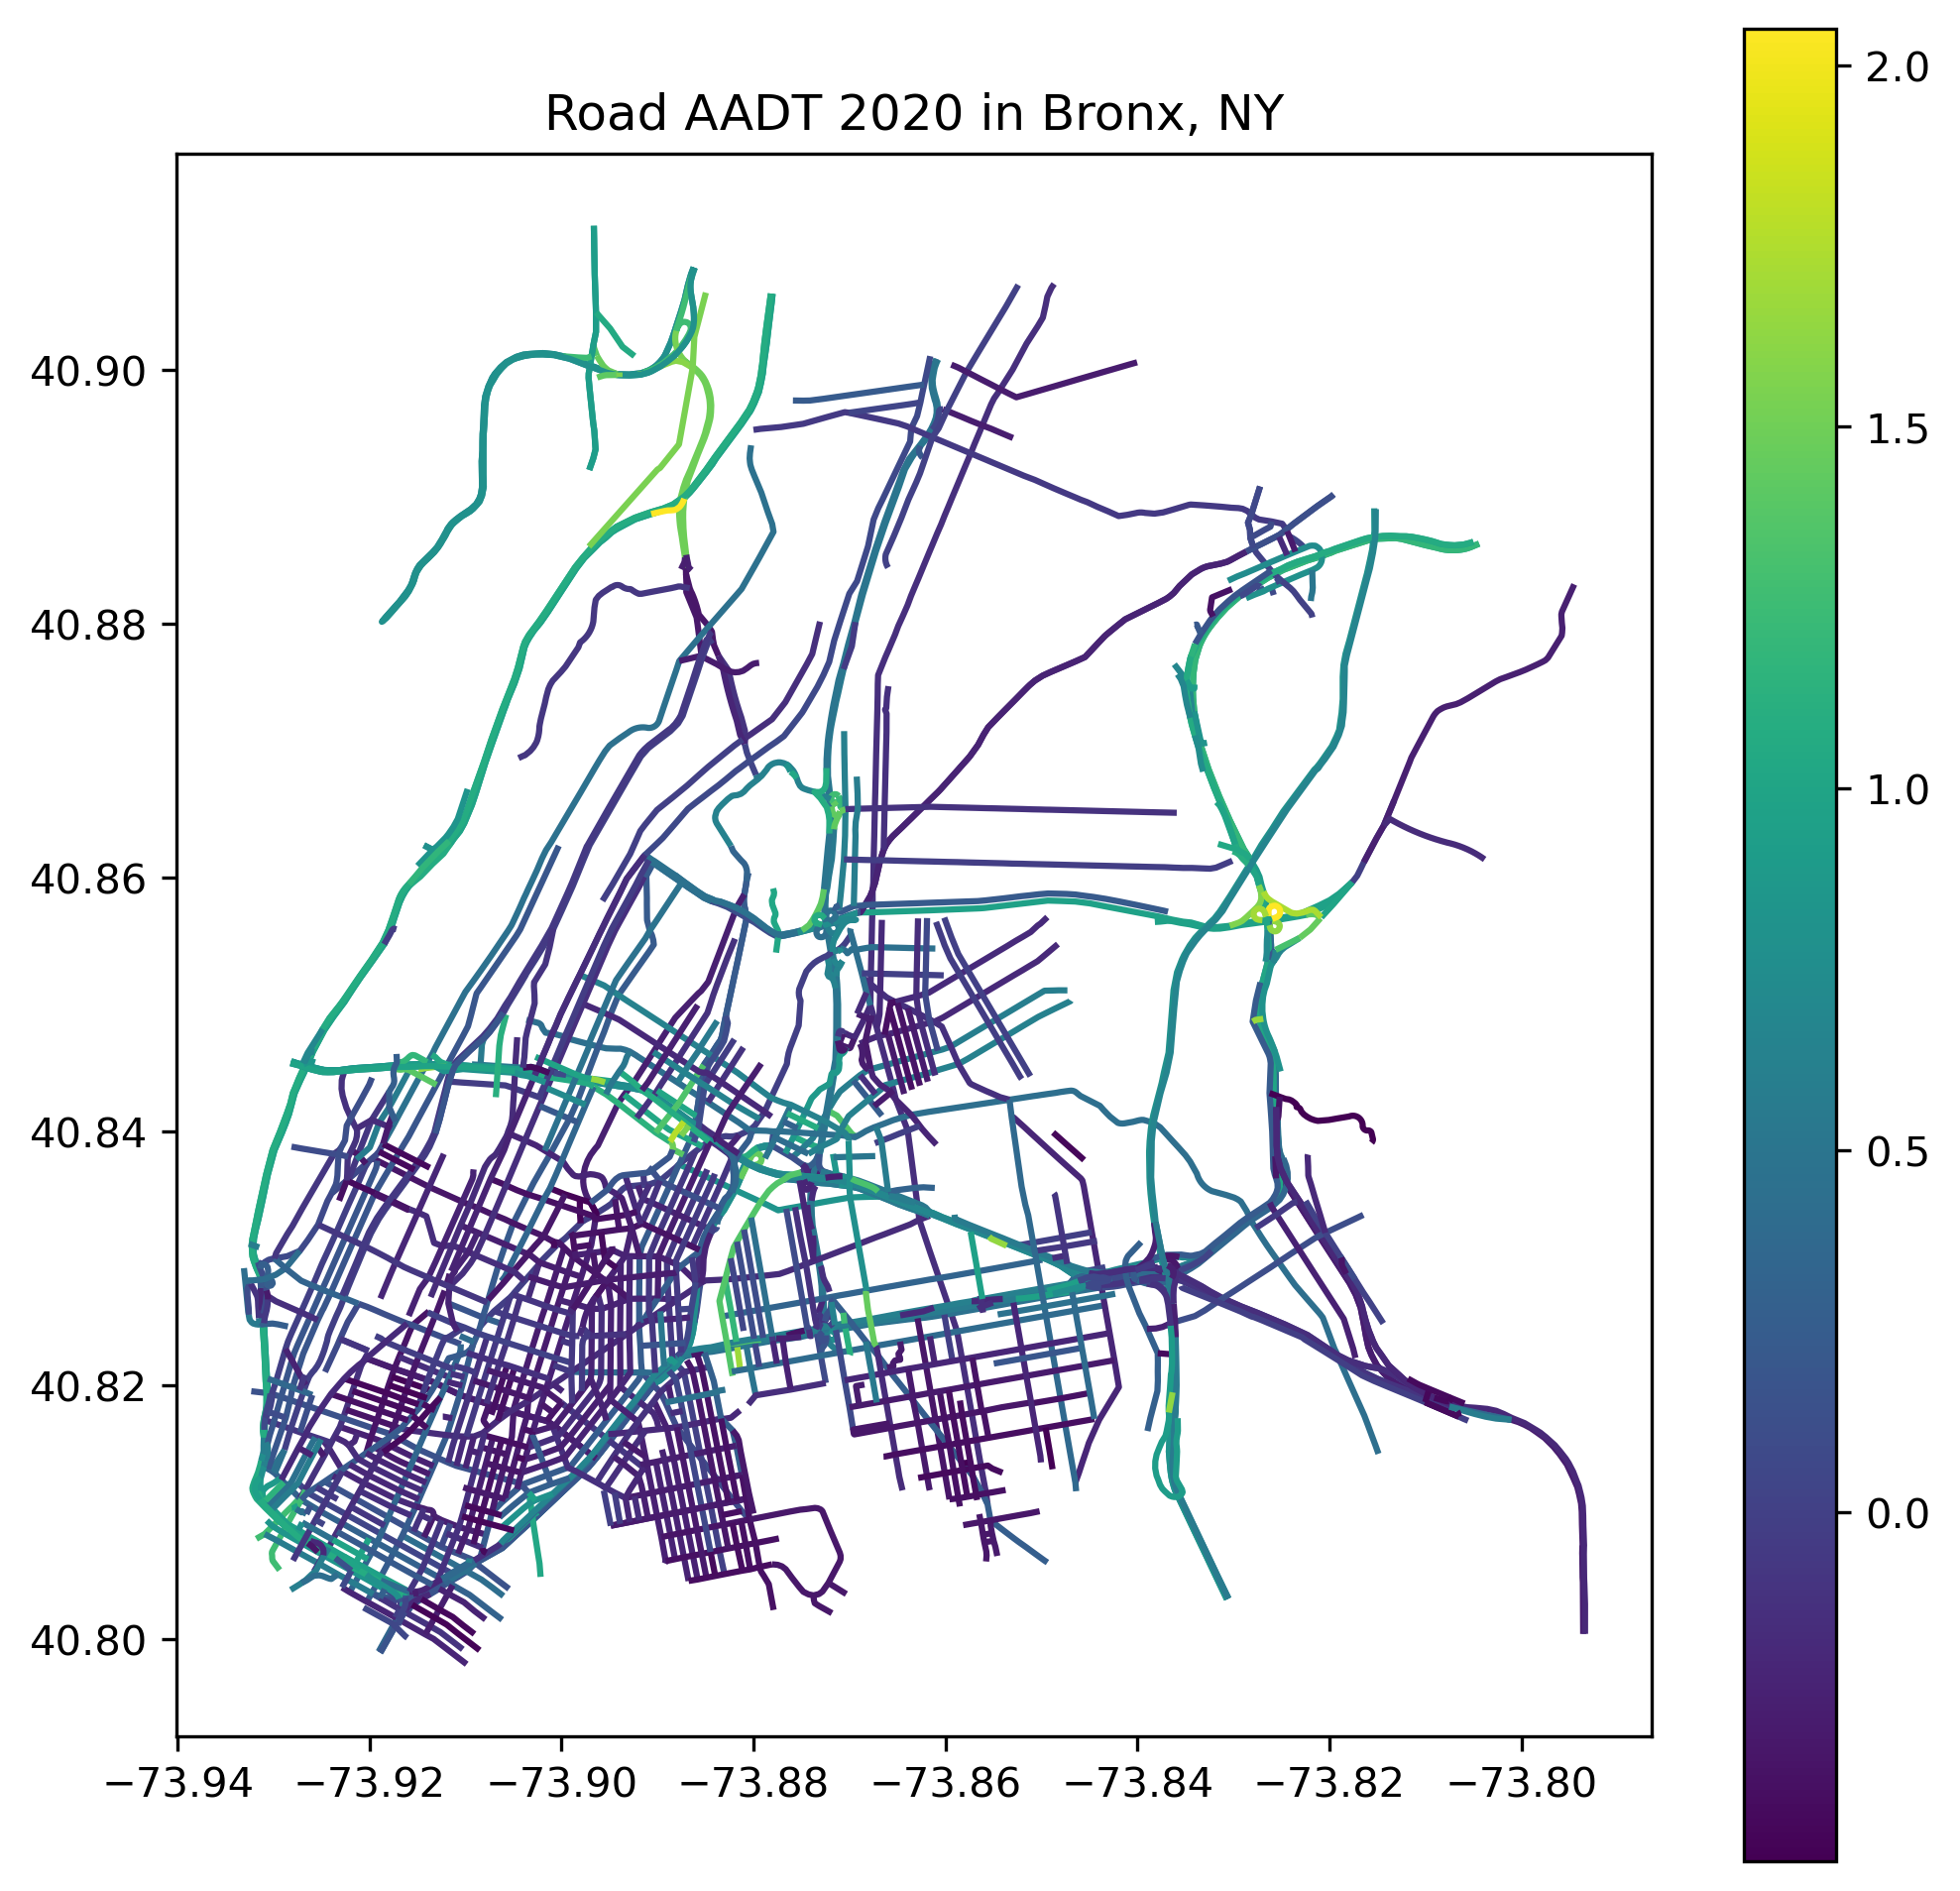

In [17]:
# make a weighted knn predictor
from sklearn.neighbors import KNeighborsRegressor

c = ["AADT_2020", "PCT_2020"]
Y = aadt[c]  # pandas
X = aadt[["longitude", "latitude"]]
knn = KNeighborsRegressor(n_neighbors=3, weights="distance")

# # remove NaNs
nan_ix = Y.isna().any(axis=1)
X = X.loc[~nan_ix]
Y = Y.loc[~nan_ix]

knn.fit(X, Y)

# predict AADT for each road, evaluate on all the points of the line and average
road_feats = []
for ix, row in tqdm(roads.iterrows(), total=roads.shape[0]):
    road = row.geometry
    lon, lat = road.xy
    Xtest = pd.DataFrame({"longitude": lon, "latitude": lat})
    preds = knn.predict(Xtest)
    road_feats.append(preds.mean(axis=0))
road_feats = np.array(road_feats)
road_feats = gpd.GeoDataFrame(
    road_feats, columns=Y.columns, geometry=roads.geometry.values, index=roads.index
)
display(road_feats)

# apply the scaled symlog transform
def scaled_symlog(x):
    m = x.median()
    iqr = np.percentile(x, 75) - np.percentile(x, 25)
    x_scaled = (x - m) / iqr
    return np.sign(x_scaled) * np.log1p(np.abs(x_scaled))


# norm = matplotlib.colors.LogNorm(vmin=roads.AADT_2019.min(), vmax=roads.AADT_2019.max())
road_feats_ = road_feats.copy()
road_feats_["AADT_2020"] = scaled_symlog(road_feats["AADT_2020"])
road_feats_.plot("AADT_2020", legend=True)
plt.title("Road AADT 2020 in Bronx, NY")

### Features by census tracts from NYC zoning

Columns: borough, tax_block, lot, cd, tract, block, ct2010, cb2010, schooldist, council, zipcode, firecomp, policeprct, healthcenterdistrict, healtharea, sanitboro, sanitdistrict, sanitsub, address, zonedist1, zonedist2, zonedist3, zonedist4, overlay1, overlay2, spdist1, spdist2, spdist3, ltdheight, splitzone, bldgclass, landuse, easements, ownertype, ownername, lotarea, bldgarea, comarea, resarea, officearea, retailarea, garagearea, strgearea, factryarea, otherarea, areasource, numbldgs, numfloors, unitsres, unitstotal, lotfront, lotdepth, bldgfront, bldgdepth, ext, proxcode, irrlotcode, lottype, bsmtcode, assessland, assesstot, exempttot, yearbuilt, yearalter1, yearalter2, histdist, landmark, builtfar, residfar, commfar, facilfar, borocode, bbl, condono, tract2010, xcoord, ycoord, zonemap, zmcode, sanborn, taxmap, edesignum, appbbl, appdate, plutomapid, firm07_flag, pfirm15_flag, version, dcpedited, latitude, longitude, notes


borough  tax_block  lot     cd  tract  block  ct2010  cb2010  \
8           BX       3032  129  206.0  38304   1001  383.02  1001.0   
9           BX       2956    2  206.0  36502   2000  365.02  2000.0   
11          BX       5413   81  210.0  27401   2001  274.01  2001.0   
12          BX       5413    9  210.0  27401   1000  274.01  1000.0   
13          BX       5413  128  210.0  27401   2000  274.01  2000.0   
...        ...        ...  ...    ...    ...    ...     ...     ...   
858391      BX       3832   10  209.0   9600   1000   96.00  1000.0   
858417      BX       2391   45  203.0  14300   1007  143.00  1016.0   
858418      BX       5744   48  208.0  29301   2000  293.01  2000.0   
858537      BX       5406   67  210.0  27401   3010  274.01  3009.0   
858543      BX       5745  105  208.0  29301   1000  293.01  1000.0   

        schooldist  council  ...        appbbl     appdate  plutomapid  \
8             10.0     15.0  ...           NaN         NaN           1   
9             12.0     15.0  ...           NaN         NaN           1   
11             8.0     13.0  ...           NaN         NaN           1   
12             8.0     13.0  ...           NaN         NaN           1   
13             8.0     13.0  ...           NaN         NaN           1   
...            ...      ...  ...           ...         ...         ...   
858391         8.0     18.0  ...           NaN         NaN           1   
858417         9.0     16.0  ...  2.023910e+09  11/16/2009           1   
858418        10.0     11.0  ...           NaN         NaN           1   
858537         8.0     13.0  ...           NaN         NaN           1   
858543        10.0     11.0  ...           NaN         NaN           1   

        firm07_flag  pfirm15_flag  version  dcpedited   latitude  longitude  \
8               NaN           NaN   24v1.1        NaN  40.860247 -73.892348   
9               NaN           NaN   24v1.1        NaN  40.843836 -73.889176   
11              NaN           NaN   24v1.1        NaN  40.846491 -73.821691   
12              NaN           NaN   24v1.1        NaN  40.847164 -73.822513   
13              NaN           NaN   24v1.1        NaN  40.847480 -73.820459   
...             ...           ...      ...        ...        ...        ...   
858391          NaN           NaN   24v1.1        NaN  40.834433 -73.848158   
858417          NaN           NaN   24v1.1        NaN  40.827105 -73.912030   
858418          NaN           NaN   24v1.1        NaN  40.881780 -73.920658   
858537          NaN           NaN   24v1.1        NaN  40.839107 -73.823196   
858543          1.0           1.0   24v1.1        NaN  40.884256 -73.921104   

       notes  
8        NaN  
9        NaN  
11       NaN  
12       NaN  
13       NaN  
...      ...  
858391   NaN  
858417   NaN  
858418   NaN  
858537   NaN  
858543   NaN  

[89061 rows x 92 columns]

  0%|          | 0/89061 [00:00<?, ?it/s]

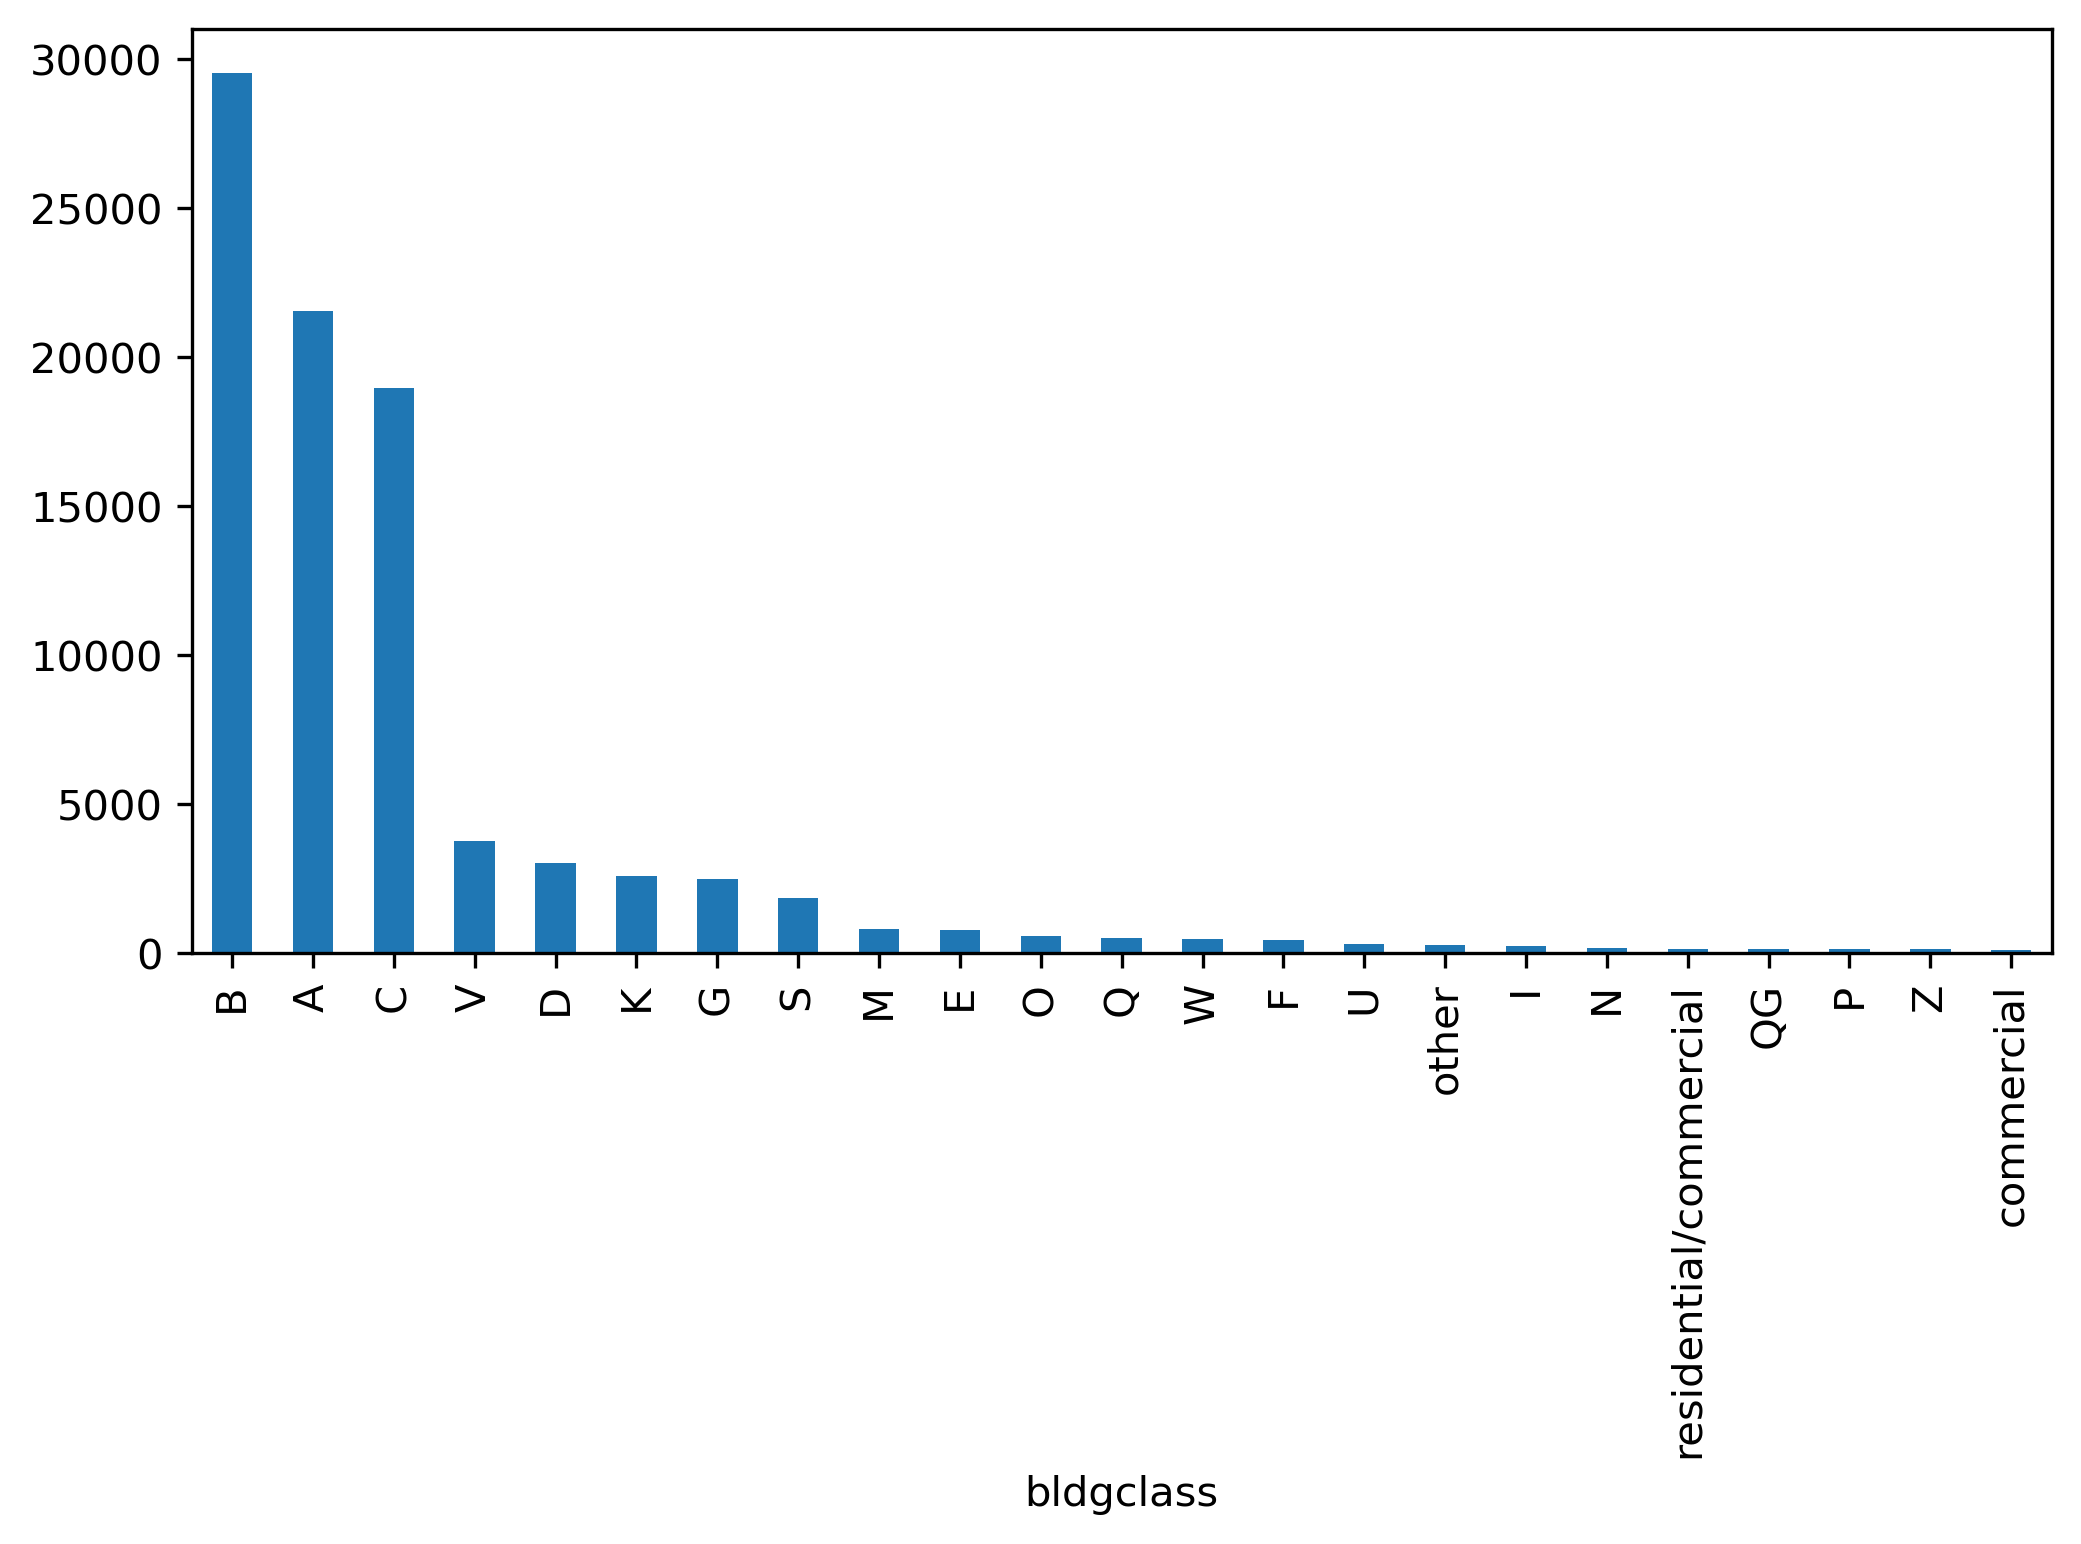

/var/folders/h3/2f91vbwj7r506n1w06610njh0000gn/T/ipykernel_91100/3966173528.py:84: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'one_two_family' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df.landuse.isin(classes), "landuse"] = new_class


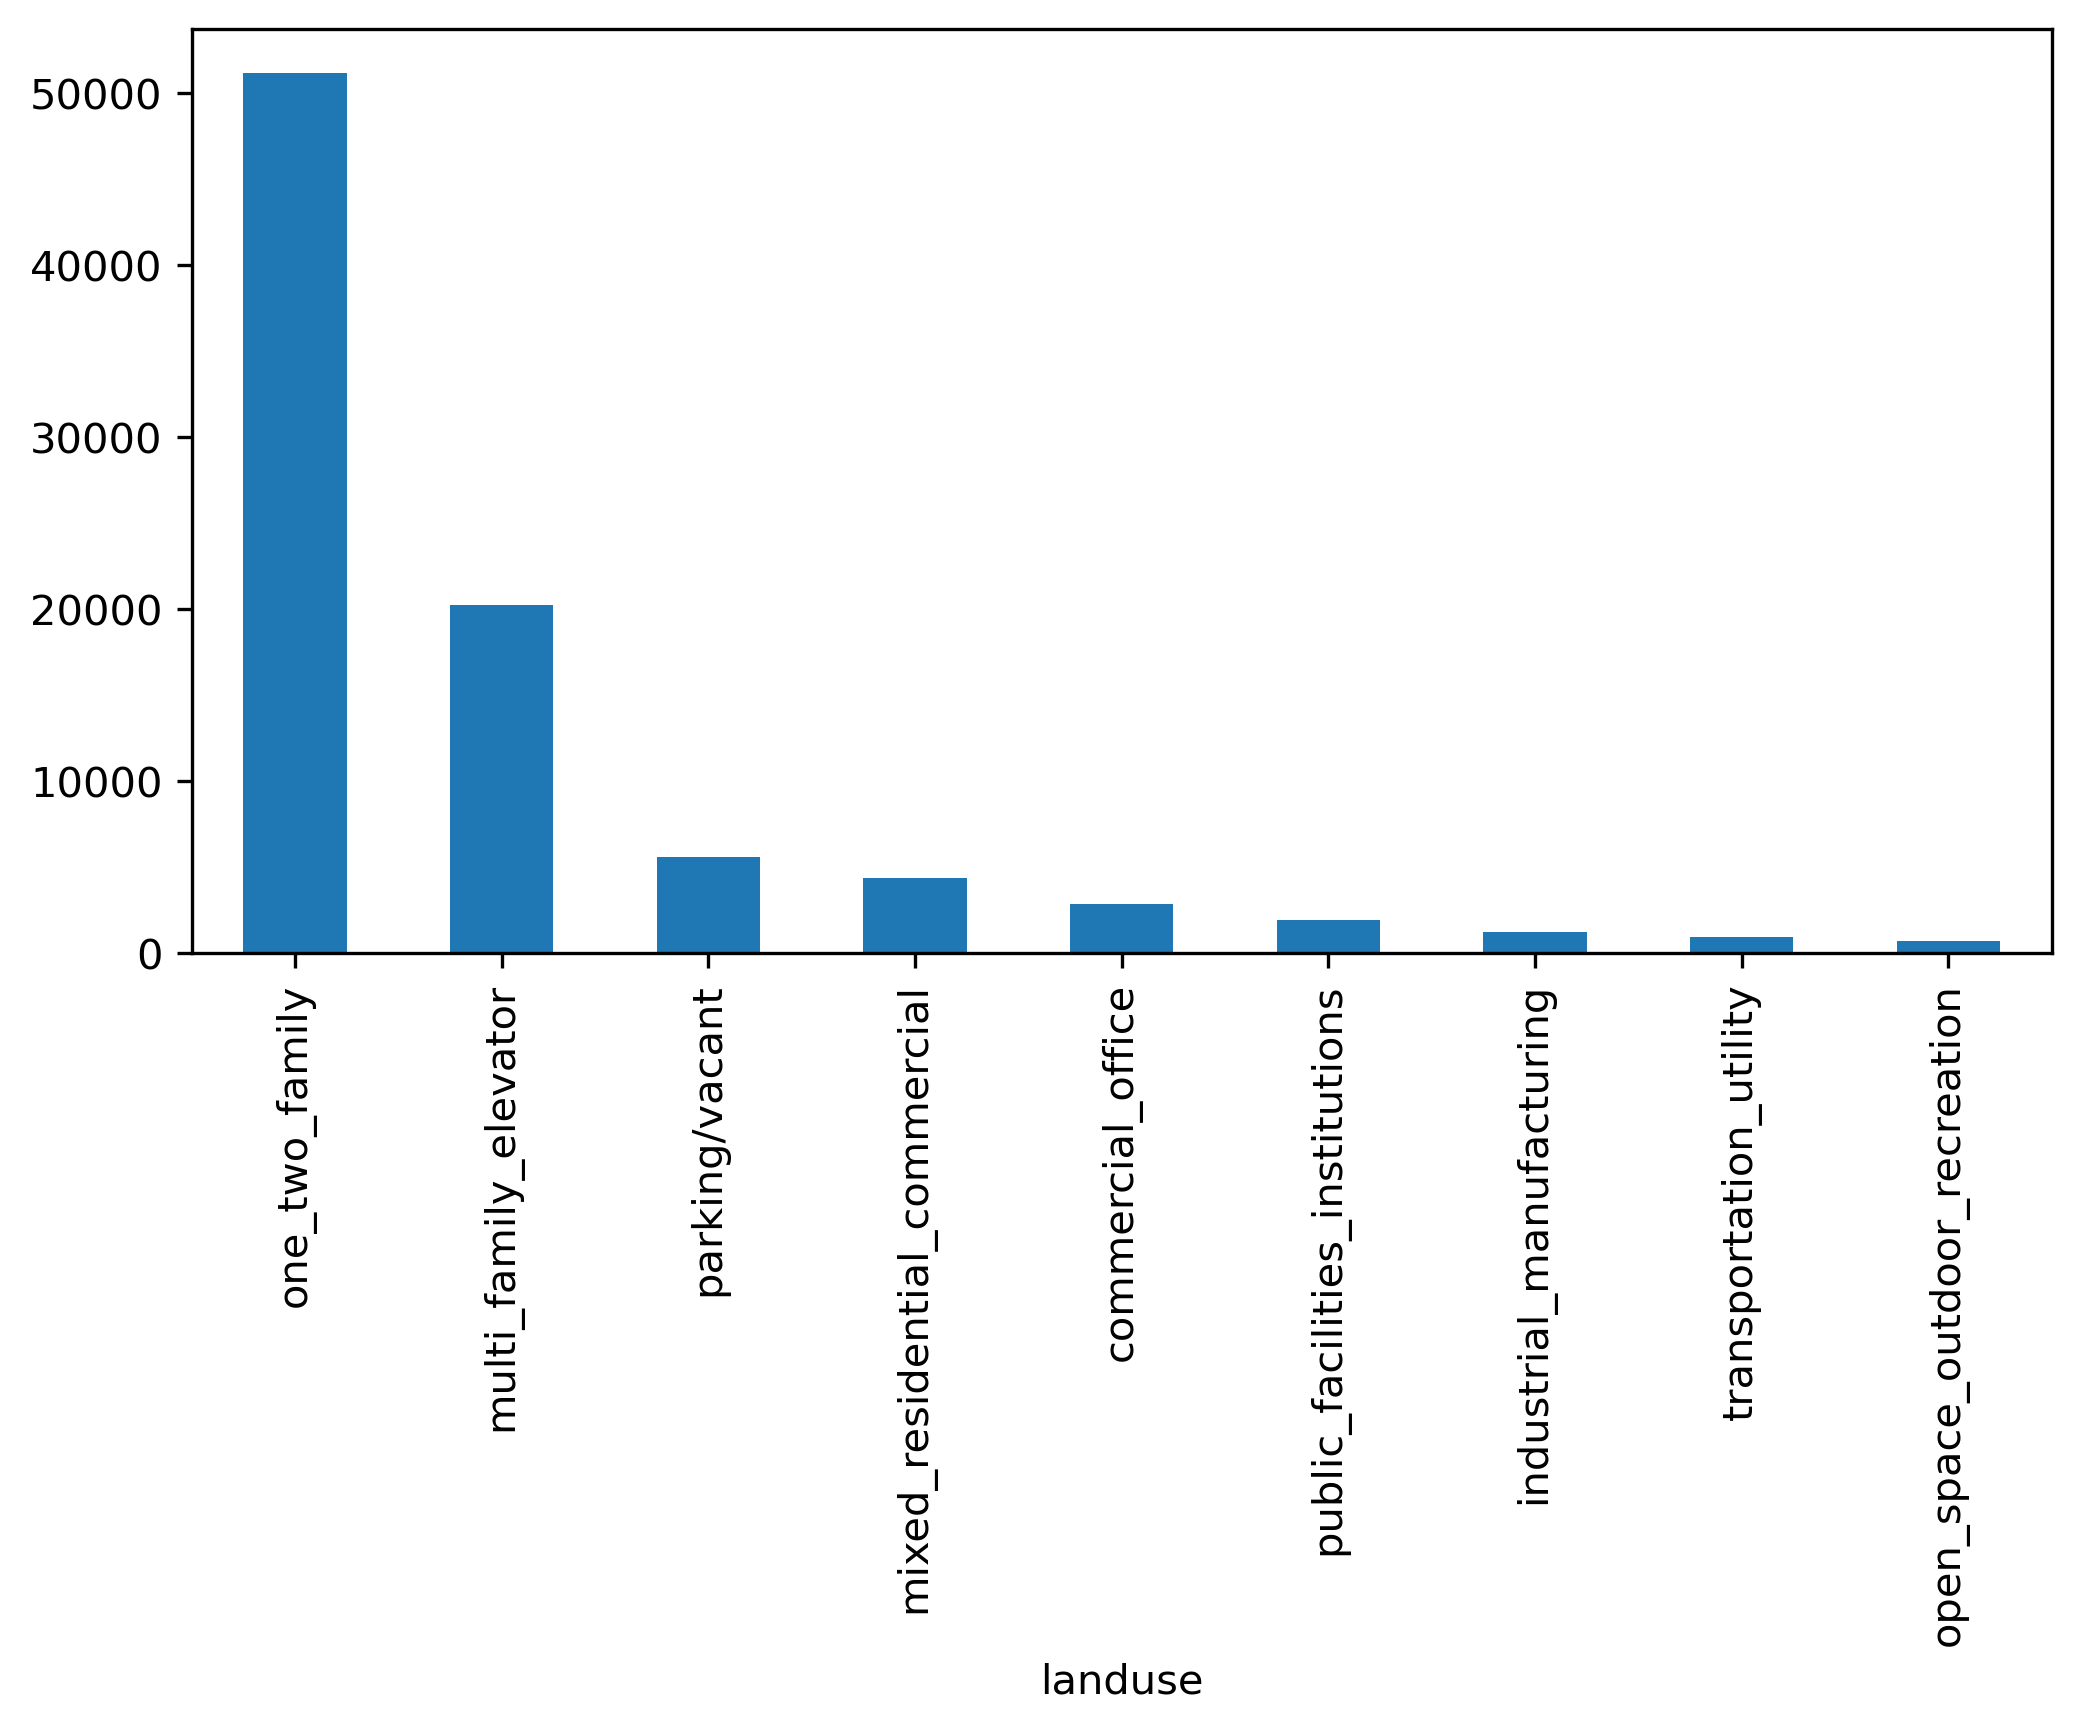

New dummy columns: bldgclass_B, bldgclass_C, bldgclass_D, bldgclass_E, bldgclass_F, bldgclass_G, bldgclass_I, bldgclass_K, bldgclass_M, bldgclass_N, bldgclass_O, bldgclass_P, bldgclass_Q, bldgclass_QG, bldgclass_S, bldgclass_U, bldgclass_V, bldgclass_W, bldgclass_Z, bldgclass_commercial, bldgclass_other, bldgclass_residential/commercial, landuse_industrial_manufacturing, landuse_mixed_residential_commercial, landuse_multi_family_elevator, landuse_one_two_family, landuse_open_space_outdoor_recreation, landuse_parking/vacant, landuse_public_facilities_institutions, landuse_transportation_utility
Columns: bldgarea, comarea, resarea, officearea, retailarea, factryarea, bldgclass_B, bldgclass_C, bldgclass_D, bldgclass_E, bldgclass_F, bldgclass_G, bldgclass_I, bldgclass_K, bldgclass_M, bldgclass_N, bldgclass_O, bldgclass_P, bldgclass_Q, bldgclass_QG, bldgclass_S, bldgclass_U, bldgclass_V, bldgclass_W, bldgclass_Z, bldgclass_commercial, bldgclass_other, bldgclass_residential/commercial, landu

id  bldgarea   comarea   resarea  officearea  retailarea  factryarea  \
0      200  0.266297  0.014688  0.230103    0.000223    0.004151    0.002596   
1      400  0.264036  0.014356  0.235935    0.000527    0.003073    0.000000   
2     1600  1.069532  0.438426  0.601089    0.081915    0.018124    0.000000   
3     1901  3.812645  0.911818  2.854734    0.216406    0.230910    0.056124   
4     1902  1.425532  0.997668  0.346947    0.081079    0.031895    0.537697   
..     ...       ...       ...       ...         ...         ...         ...   
187  46207  1.902246  1.902246  0.000000    0.000000    0.848956    0.000000   
188  46208  0.749733  0.234175  0.472438    0.006867    0.017525    0.022294   
189  46209  0.655938  0.287899  0.348172    0.018474    0.050552    0.048227   
190  48401  0.620076  0.222253  0.355940    0.007100    0.023833    0.076555   
191  50400  0.002895  0.002895  0.000000    0.000679    0.000016    0.000000   

     bldgclass_B  bldgclass_C  bldgclass_D  ...  landuse_parking/vacant  \
0       0.000158     0.000048     0.000000  ...                0.000664   
1       0.000168     0.000035     0.000000  ...                0.000255   
2       0.000282     0.000186     0.000360  ...                0.000398   
3       0.000000     0.000762     0.004234  ...                0.001818   
4       0.000122     0.000138     0.000110  ...                0.000204   
..           ...          ...          ...  ...                     ...   
187     0.000000     0.000000     0.000000  ...                0.000000   
188     0.000390     0.000161     0.000000  ...                0.000085   
189     0.000181     0.000156     0.000863  ...                0.000468   
190     0.000314     0.000160     0.000000  ...                0.000158   
191     0.000000     0.000000     0.000000  ...                0.000596   

     landuse_public_facilities_institutions  landuse_transportation_utility  \
0                                  0.000015                        0.000000   
1                                  0.000015                        0.000002   
2                                  0.000718                        0.000000   
3                                  0.000550                        0.000204   
4                                  0.000065                        0.000541   
..                                      ...                             ...   
187                                0.000000                        0.000000   
188                                0.000135                        0.000082   
189                                0.000105                        0.000709   
190                                0.000091                        0.000157   
191                                0.000000                        0.000964   

      lotarea  assesstot    lotfront    lotdepth   bldgfront   bldgdepth  \
0    0.583213   0.000214    0.339109    0.434072    0.010054    0.018615   
1    0.849728   0.008111    0.410327    0.761597    0.036500    0.028083   
2    0.333306   0.032768    0.888606    0.890461    0.279794    0.294793   
3    0.069696   0.181801    2.123340    2.481584    1.475738    1.472475   
4    0.226121   0.004670    0.469884    0.557185    0.279010    0.335857   
..        ...        ...         ...         ...         ...         ...   
187  0.026264  27.613800  278.330000  676.000000  438.000000  292.000000   
188  0.277534   0.002281    0.141136    0.174394    0.063518    0.074325   
189  0.316518   0.011394    0.886363    1.003565    0.366606    0.289836   
190  0.325851   0.001353    0.125650    0.199098    0.068545    0.075266   
191  9.055977   7.258759   60.549527  267.164490    1.408605    0.497155   

                                              geometry  
0    POLYGON ((-73.86648 40.80590, -73.86222 40.810...  
1    POLYGON ((-73.85870 40.81540, -73.85778 40.815...  
2    POLYGON ((-73.86246 40.81925, -73.86153 40.819...  
3    POLYGON ((-73.93094 40.80825, -73.92933 40.809...  

Text(0.5, 1.0, 'Retailarea in Bronx, NY')

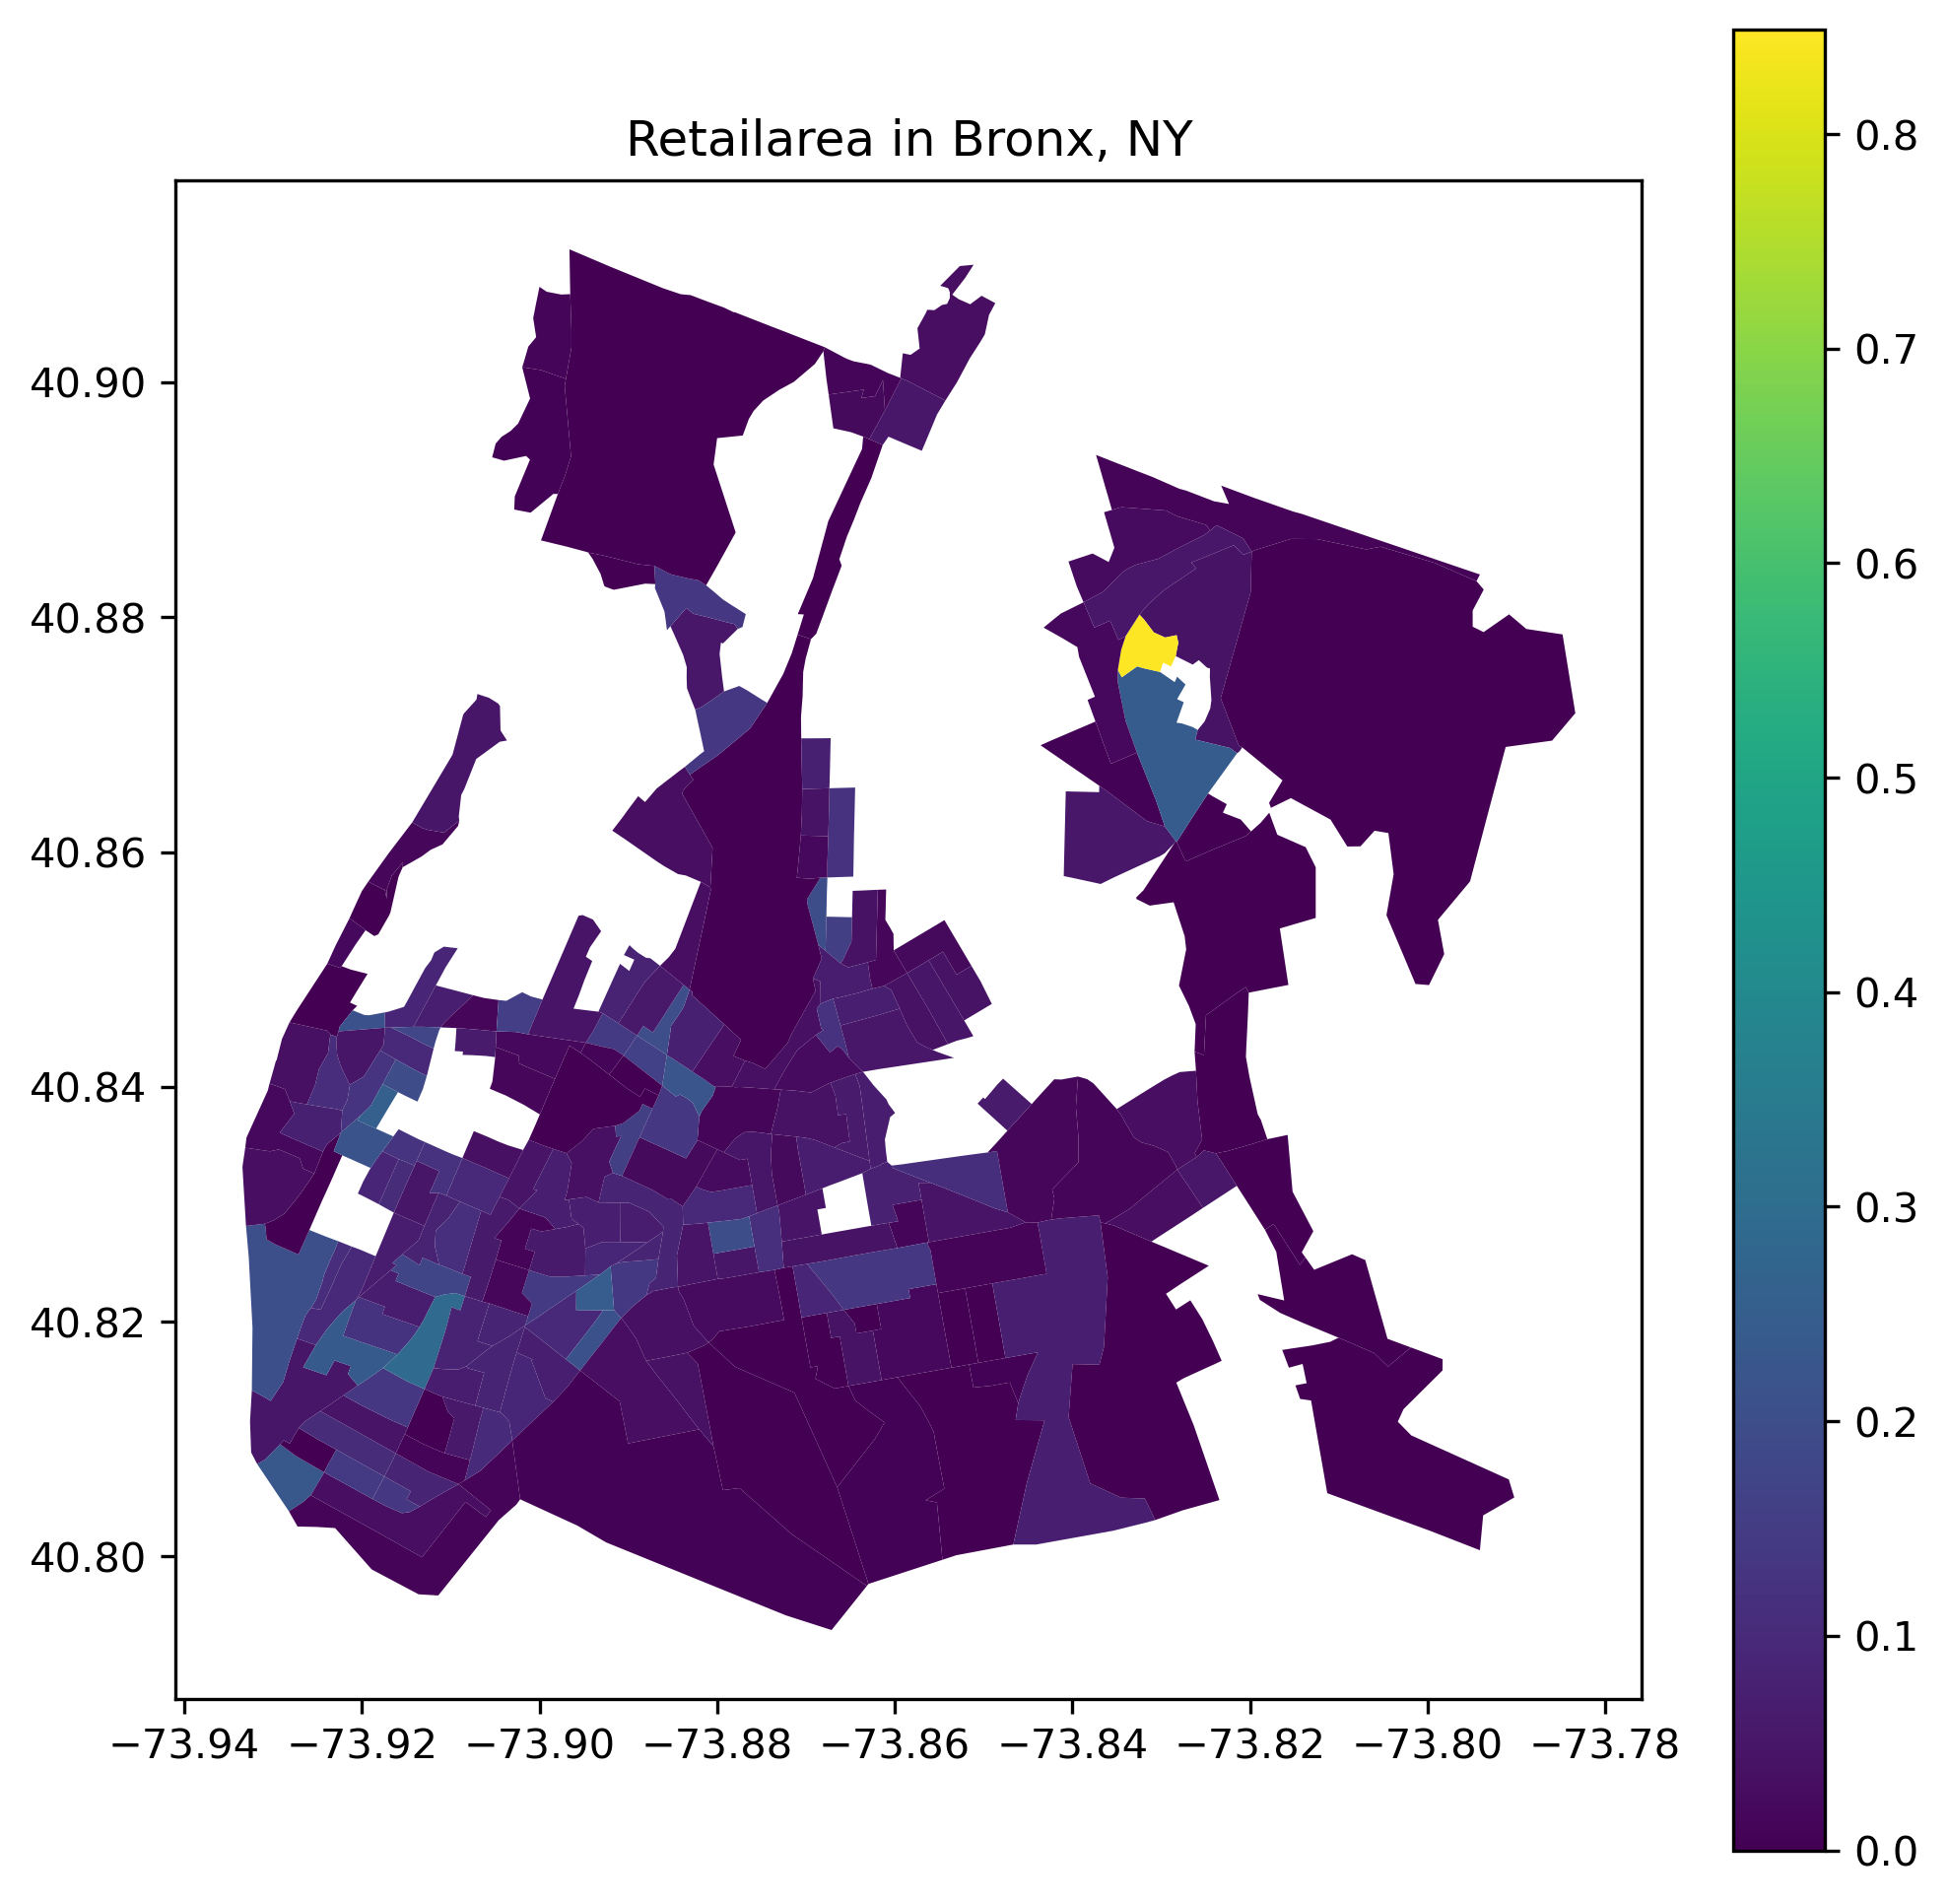

In [18]:
import re

# Primary Land Use Tax Lot Output (PLUTO)
# crs=2263, used in NYC commonly, convert to WGS84
df = pd.read_csv("data/raw/nyc_pluto_24v1_1_csv/pluto_24v1_1.csv", low_memory=False)
df.rename(columns={"block": "tax_block"}, inplace=True)
df.rename(columns={"bctcb2020": "block"}, inplace=True)
df.rename(columns={"bct2020": "tract"}, inplace=True)
print("Columns:", ", ".join(df.columns))

# remove NaNs from bctcb2020zw
df = df[df.borough == "BX"]

# process as string and keep only last 4 digits
df = df[df.block.notna() & df.landuse.notna() & df.bldgclass.notna()]
df["block"] = df["block"].astype(int).astype(str).str[-4:].astype(int)
df["tract"] = df["tract"].astype(int).astype(str).str[-6:].astype(int)
display(df)

# transform assesstot to millions of dollar
df["assesstot"] = df["assesstot"] / 1e6

# categorical variables to be made one-hot and summed
cat_cols = ["bldgclass", "landuse"]


# preprocess building class
# see pluto data dictionary
mapping = [
    (["R5", "R7", "R8", "RA", "RB", "RH", "RK", "RD"], "residential"),
    (["R1", "R2", "R3", "R4", "R6", "RR", "RC"], "commercial"),
    (["R9", "RM"], "residential/commercial"),
    (["RI", "RW"], "industrial/warehouse"),
    (["RZ"], "residential/industrial"),
    (["RG", "RP", "RS", "RT"], "parking/storage/terraces"),
]

# map classes
for classes, new_class in mapping:
    df.loc[df.bldgclass.isin(classes), "bldgclass"] = new_class

# for the rest, remove the number, just keep the lettter
new_vals = []
for ix, row in tqdm(df.iterrows(), total=df.shape[0]):
    val = row.bldgclass
    if val not in [x[1] for x in mapping]:
        val = re.sub(r"[0-9]", "", val)
    new_vals.append(val)
df["bldgclass"] = new_vals

# make all classes that appear less than 100 times as "other"
cnts = df.bldgclass.value_counts()
df.loc[df.bldgclass.isin(cnts[cnts < 100].index), "bldgclass"] = "other"

# display counts
# display(df.bldgclass.value_counts())
plt.figure(figsize=(8, 4))
df.bldgclass.value_counts().plot(kind="bar")
plt.show()

area_feats = [
    "bldgarea",
    "comarea",
    "resarea",
    "officearea",
    "retailarea",
    "factryarea",
]

# map land use
mapping = [
    ([1], "one_two_family"),
    ([2, 3], "multi_family_elevator"),
    ([4], "mixed_residential_commercial"),
    ([5], "commercial_office"),
    ([6], "industrial_manufacturing"),
    ([7], "transportation_utility"),
    ([8], "public_facilities_institutions"),
    ([9], "open_space_outdoor_recreation"),
    ([10, 11], "parking/vacant"),
]
df["landuse"] = df["landuse"].astype(int)
for classes, new_class in mapping:
    df.loc[df.landuse.isin(classes), "landuse"] = new_class


# display counts
plt.figure(figsize=(8, 4))
df.landuse.value_counts().plot(kind="bar")
plt.show()

# features to be averaged by LotArea
av_feats = ["assesstot", "lotfront", "lotdepth", "bldgfront", "bldgdepth"]

orig_cols = df.columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True, prefix=cat_cols)
new_cat_cols = list(df.columns.difference(orig_cols))
print("New dummy columns:", ", ".join(new_cat_cols))

# do groupby, start with sum
dfagg = df.groupby(["tract"])[
    area_feats + new_cat_cols + ["lotarea"]
].sum()


# now compute an weighted average of av_feats by LotArea
def nan_weighted_mean(x, wts):
    isna = np.isnan(x) | np.isnan(wts)
    x = x[~isna]
    wts = wts[~isna] + 1e-6
    return np.nanmean(x * wts) / np.nansum(wts)


for col in av_feats + new_cat_cols:
    dfagg[col] = df.groupby("tract")[[col, "lotarea"]].apply(
        lambda x: nan_weighted_mean(x[col].values, x.lotarea.values)
    )


# transform the count and area features to density and pcts respectively by dividing by lotarea
for col in area_feats:
    dfagg[col] = dfagg[col] / dfagg["lotarea"]

# transform lot area from squared feed to squared kilometers
dfagg["lotarea"] = dfagg["lotarea"] * 0.000000092903

# remove nans
dfagg = dfagg.dropna()
print("Columns:", ", ".join(dfagg.columns))

# find the elements in dfagg.index that are also in tracts.TRACTCE
indexes = dfagg.index[dfagg.index.isin(tracts.index)]
dfagg = dfagg.loc[indexes]
tracts = tracts.loc[indexes]

# convert to gpd
tract_feats = gpd.GeoDataFrame(
    dfagg, geometry=tracts.geometry.loc[dfagg.index], crs=tracts.crs, index=dfagg.index
)
tract_feats = tract_feats.reset_index()
tract_feats = tract_feats.rename({"tract": "id"}, axis=1)
display(tract_feats)

# plot features as an example
# bldgdepth
tract_feats_ = tract_feats.copy()
# tract_feats_["retailarea"] = scaled_symlog(tract_feats_["retailarea"])
tract_feats_.plot("retailarea", legend=True)
plt.title("Retailarea in Bronx, NY")

### Open Street Map features by Census Tract

### WIP 

(but I don't think we'll need it. It could provide more detialed information like restaurants, but it is besides the point)

In [19]:
# # Step 1: Define your area of interest
# place_name = "Bronx, New York, USA"

# # Step 2: Download road network and points of interest (POIs)
# network_type = 'drive'
# streets = ox.graph_from_place(place_name, network_type=network_type)
# gdf_streets = ox.graph_to_gdfs(streets, nodes=False)
# gdf_streets

### Export

#### TODO

1. save each feature separately
2. save a rank 0 tagging
3. compute adjacency graphs
4. compute knn graph for rank 0 as optional

### Compute adjacency graphs

First the KNN graph for points

In [20]:
# generate knn graph with k=4 for points
# save knn graph as list of edges
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=3, metric="euclidean")
lon = pts_feats.geometry.x.values
lat = pts_feats.geometry.y.values
coords = np.stack([lon, lat], axis=1)
knn.fit(coords)
distances, indices = knn.kneighbors(coords)
edges_pts = []
for ix, row in tqdm(enumerate(indices), total=indices.shape[0]):
    for i in row:
        edges_pts.append([int(ix), int(i)])
print("Number of points:", pts_feats.shape[0])
print("Number of edges of KNN(4) graph on points:", len(edges_pts))

  0%|          | 0/58723 [00:00<?, ?it/s]

Number of points: 58723
Number of edges of KNN(4) graph on points: 176169


Now the spatial intersection of roads

In [21]:
# road_feats_geom_buff = road_feats.geometry.to_crs("EPSG:3857").buffer(5).to_crs("EPSG:4326")
# # self adjacency
# gdfr = gpd.GeoDataFrame(geometry=road_feats_geom_buff)
sjoin = gpd.sjoin(roads_buff, roads_buff, predicate="intersects", how="inner")
edges_roads = []
for ix, row in tqdm(sjoin.iterrows(), total=sjoin.shape[0]):
    if ix != row.index_right:
        edges_roads.append([int(ix), int(row.index_right)])
print("Number of roads:", road_feats.shape[0])
print("Number of edges of adjacency graph on roads:", len(edges_roads))

  0%|          | 0/7484 [00:00<?, ?it/s]

Number of roads: 786
Number of edges of adjacency graph on roads: 6698


Now the spatial intersection of tracts

In [22]:
# tract_feats_geom_buff = tract_feats.geometry.to_crs("EPSG:3857").buffer(5).to_crs("EPSG:4326")
# # self adjacency
# gdft = gpd.GeoDataFrame(geometry=tract_feats_geom_buff)
sjoin = gpd.sjoin(tract_buff, tract_buff, predicate="intersects", how="inner")
edges_tracts = []
for ix, row in tqdm(sjoin.iterrows(), total=sjoin.shape[0]):
    if ix != row.index_right:
        edges_tracts.append([int(ix), int(row.index_right)])
print("Number of tracts:", tract_feats.shape[0])
print("Number of edges of adjacency graph on tracts:", len(edges_tracts))

  0%|          | 0/1190 [00:00<?, ?it/s]

Number of tracts: 192
Number of edges of adjacency graph on tracts: 998


In [23]:
schema = {
    "$schema": "http://json-schema.org/draft-07/schema#",
    "type": "object",
    "properties": {
        "x_i": {
            "type": "array",
            "items": {"type": "array", "items": {"type": "number"}},
            "description": "Features of cells with rank i.",
        },
        "y": {
            "type": "array",
            "items": {"type": "array", "items": {"type": "number"}},
            "description": "Targets, shaped as either (1, num_targets) for graph-level prediction or (num_atoms, num_targets) for node-level prediction.",
        },
        "pos": {
            "type": "array",
            "items": {
                "type": "array",
                "items": {"type": "number", "minItems": 3, "maxItems": 3},
            },
            "description": "Atom positions.",
        },
        "cell_i": {
            "type": "array",
            "items": {"type": "array", "items": {"type": "integer"}},
            "description": "Atom indices of cells with rank i.",
        },
        "adj_i_j": {
            "type": "array",
            "items": {
                "type": "array",
                "minItems": 2,
                "maxItems": 2,
                "items": {"type": "integer"},
            },
            "description": "Connections between cells of rank i and rank j (i != j).",
        },
        "adj_i_i_foo": {
            "type": "array",
            "items": {
                "type": "array",
                "minItems": 2,
                "maxItems": 2,
                "items": {"type": "integer"},
            },
            "description": "Connections between cells of rank i and rank i, induced by neighborhood function foo.",
        },
    },
    "required": ["x_i", "y", "pos", "cell_i", "adj_i_j", "adj_i_i_foo"],
}

In [34]:
edges_pts_road_transponse = np.array(edges_pts_road).T.tolist()
edges_road_tract_transponse = np.array(edges_road_tract).T.tolist()
edges_pts_transponse = np.array(edges_pts).T.tolist()
edges_roads_transponse = np.array(edges_roads).T.tolist()
edges_tract_transponse = np.array(edges_tracts).T.tolist()

data = {
    "x_0": pts_feats.drop(columns=["geometry"]).values.tolist(),
    "x_1": road_feats.drop(columns=["geometry"]).values.tolist(),
    "x_2": tract_feats.drop(columns=["geometry"]).values.tolist(),
    "pos": pts_feats.geometry.apply(lambda x: [x.x, x.y]).values.tolist(),
    "cell_0": cell_0,
    "cell_1": cell_1,
    "cell_2": cell_2,
    "adj_0_1": edges_pts_road_transponse,
    "adj_1_2": edges_road_tract_transponse,
    "adj_0_0": edges_pts_transponse,
    "adj_1_1": edges_roads_transponse,
    "adj_2_2": edges_tract_transponse,
    "y": y.drop(columns=["geometry"]).values.tolist(),
    "num_features_dict": {
        0: pts_feats.shape[1],
        1: road_feats.shape[1],
        2: tract_feats.shape[1],
    },
}

with open("data/raw/spatial_cc.json", "w") as f:
    json.dump(data, f)

In [35]:
# save pts vmap
pts[["road", "tract"]].to_csv("data/raw/point_to_cell.csv", index=False)

In [36]:
# count None in cell_0, cell_1, cell_2
print("Number of None in cell_0", sum(1 for c in cell_0 if not c))
print("Number of None in cell_1", sum(1 for c in cell_1 if not c))
print("Number of None in cell_2", sum(1 for c in cell_2 if not c))

Number of None in cell_0 0
Number of None in cell_1 0
Number of None in cell_2 0


In [31]:
print(np.array(data['adj_0_0']).shape)

(2, 176169)
